<a href="https://colab.research.google.com/github/LilyJ01/-schulich_data_science/blob/main/AICP_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Spectral Data Processing

In first part, we parsed ASD files to extract wavelength and reflectance values, calculating reflectance as needed. Next, we sorted the dataset by file names in natural order and ensured wavelengths were arranged from 350nm to 2500nm before saving the cleaned reflectance table. After that, we applied Continuum Correction to normalize spectral curves, enhancing absorption features for better mineral identification. Finally, we reshaped the dataset from long format to wide format and each sample had all wavelengths as individual columns. so it become easy for merging with excel data.

## 1.1 Parsing ASD Data

In [229]:
# Upload the asd file from a zip
from google.colab import files
uploaded = files.upload()

Saving FCD-ASD-files.zip to FCD-ASD-files (2).zip


In [230]:
import zipfile
import os

# Extract the zip file to this folder
zip_file_name = "/content/FCD-ASD-files.zip"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("extracted_folder")

In [231]:
 # List extracted files
os.listdir("extracted_folder")

['FCD-ASD-files', '__MACOSX']

In [232]:
# Check the destination folder for .asd files
FCD_folder = "/content/extracted_folder/FCD-ASD-files"
files = os.listdir(FCD_folder)
print(f"Number of .asd files in the destination folder: {len(files)}")
print(f"Sample files: {files[:5]}")

Number of .asd files in the destination folder: 288
Sample files: ['FCD-24-082-70.70-72.07.asd', 'FCD-24-082-411.85-413.80.asd', 'FCD-24-082-378.85-380.39.asd', 'FCD-24-082-65.13-67.07.asd', 'FCD-24-082-400.22-402.09.asd']


In [233]:
!pip install specdal

In [234]:
import specdal
import pandas as pd

In [235]:
def parse_asd_files_with_wavelength(folder_path):
    """
    Reads all .asd files in the given folder and combines reflectance data with wavelengths.
    :param folder_path: Path to the folder containing ASD files.
    :return: A DataFrame with combined wavelengths, reflectance, and file information.
    """

    all_data = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".asd"):  # Process only .asd files
            file_path = os.path.join(folder_path, file_name)
            try:
                # Read the ASD file
                spectrum = specdal.read(file_path)
                spectral_data = spectrum[0]  # Access spectral data (DataFrame)

                # Add reflectance (tgt_count / ref_count)
                spectral_data["reflect"] = spectral_data["tgt_count"] / spectral_data["ref_count"]

                # Add the file name for traceability
                spectral_data["file_name"] = file_name

                # Include wavelength as a column (index reset to include it explicitly)
                spectral_data.reset_index(inplace=True)  # Wavelength is in the index
                spectral_data.rename(columns={"index": "wavelength"}, inplace=True)

                # Append the spectral data
                all_data.append(spectral_data)

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    # Combine all DataFrames
    combined_data = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()
    return combined_data

In [236]:
folder_path = "/content/extracted_folder/FCD-ASD-files"  # Path to the FCD folder
asd_df = parse_asd_files_with_wavelength(folder_path)

In [237]:
# Preview Data
print(asd_df.head())

   wavelength  tgt_count  ref_count   reflect                   file_name
0       350.0  22.300983  46.059449  0.484178  FCD-24-082-70.70-72.07.asd
1       351.0  22.685006  47.196434  0.480651  FCD-24-082-70.70-72.07.asd
2       352.0  24.076650  49.607220  0.485346  FCD-24-082-70.70-72.07.asd
3       353.0  25.055859  51.518983  0.486342  FCD-24-082-70.70-72.07.asd
4       354.0  25.704099  53.159010  0.483532  FCD-24-082-70.70-72.07.asd


In [238]:
asd_df.info()
asd_df.describe(include="all").transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619488 entries, 0 to 619487
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   wavelength  619488 non-null  float64
 1   tgt_count   619488 non-null  float64
 2   ref_count   619488 non-null  float64
 3   reflect     619488 non-null  float64
 4   file_name   619488 non-null  object 
dtypes: float64(4), object(1)
memory usage: 23.6+ MB


count unique                         top  freq          mean  \
wavelength  619488.0    NaN                         NaN   NaN        1425.0   
tgt_count   619488.0    NaN                         NaN   NaN   7071.766524   
ref_count   619488.0    NaN                         NaN   NaN  20257.275016   
reflect     619488.0    NaN                         NaN   NaN      0.347402   
file_name     619488    288  FCD-24-082-70.70-72.07.asd  2151           NaN   

                     std        min           25%           50%          75%  \
wavelength    620.940649      350.0         887.0        1425.0       1963.0   
tgt_count     4349.75136   6.968708    3559.00434   6981.551732  10128.33205   
ref_count   10749.189034  28.816521  11567.803513  22145.051314  29413.39362   
reflect         0.092076   0.098767      0.279228      0.350578     0.416168   
file_name            NaN        NaN           NaN           NaN          NaN   

                     max  
wavelength        2500.0  
tgt_count   27991.383277  
ref_count   51140.671141  
reflect         0.641441  
file_name            NaN

In [239]:
# Preview the file names
print("First 10 file names in current order:")
print(asd_df['file_name'].unique()[:10])

First 10 file names in current order:
['FCD-24-082-70.70-72.07.asd' 'FCD-24-082-411.85-413.80.asd'
 'FCD-24-082-378.85-380.39.asd' 'FCD-24-082-65.13-67.07.asd'
 'FCD-24-082-400.22-402.09.asd' 'FCD-24-082-541.55-543.64.asd'
 'FCD-24-082-142.21-143.38.asd' 'FCD-24-082-507.78-510.13.asd'
 'FCD-24-082-40.92-42.06.asd' 'FCD-24-082-402.09-404.08.asd']


In [240]:
# Check for missing values
print("Missing values:\n", asd_df.isnull().sum())

Missing values:
 wavelength    0
tgt_count     0
ref_count     0
reflect       0
file_name     0
dtype: int64


In [241]:
folder_path = "/content/extracted_folder/FCD-ASD-files"  # Path to the FCD folder
combined_reflectance_data = parse_asd_files_with_wavelength(folder_path)

# Save the combined data
combined_reflectance_data.to_csv("combined_reflectance_data.csv", index=False)
print("Combined data saved to combined_reflectance_data.csv")

Combined data saved to combined_reflectance_data.csv


## 1.2 Sort and Save the table with reflectance value

In [242]:
import re

In [243]:
# Sorting by File Names
def improved_natural_sort_key(s):
    """
    Generate a key for natural sorting of strings.
    :param s: The input string.
    :return: A key for natural sorting.
    """
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('(\d+)', s)]

# Sort by file_name using improved natural sorting
asd_df['file_name'] = asd_df['file_name'].astype(str)  # Ensure all filenames are strings
data = asd_df.sort_values(by="file_name", key=lambda col: col.map(improved_natural_sort_key))

In [244]:
# Sort wavelengths within each file while maintaining the file order
data = data.groupby("file_name", sort=False).apply(lambda x: x.sort_values(by="wavelength")).reset_index(drop=True)

<ipython-input-244-a5f3b1bf8982>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("file_name", sort=False).apply(lambda x: x.sort_values(by="wavelength")).reset_index(drop=True)


In [245]:
# Save the fully sorted data
data.to_csv("sorted_reflectance_data.csv", index=False)
print("Data fully sorted and saved.")

# Validate the output
print("First 5 rows:\n", data.head())
print("Last 5 rows:\n", data.tail())

# Verify the unique filenames are in correct order
unique_files = data['file_name'].unique()
print("First file:", unique_files[0])
print("Last file:", unique_files[-1])

Data fully sorted and saved.
First 5 rows:
    wavelength  tgt_count  ref_count   reflect                 file_name
0       350.0   7.581340  45.942530  0.165018  FCD-24-082-0.00-2.85.asd
1       351.0   6.968708  46.882254  0.148643  FCD-24-082-0.00-2.85.asd
2       352.0   7.747785  49.455336  0.156662  FCD-24-082-0.00-2.85.asd
3       353.0   8.119050  51.733904  0.156939  FCD-24-082-0.00-2.85.asd
4       354.0   8.021562  53.540683  0.149822  FCD-24-082-0.00-2.85.asd
Last 5 rows:
         wavelength   tgt_count    ref_count   reflect  \
619483      2496.0  348.525763  1401.993909  0.248593   
619484      2497.0  338.903261  1364.288145  0.248410   
619485      2498.0  329.189224  1325.074352  0.248431   
619486      2499.0  318.981274  1284.401299  0.248350   
619487      2500.0  308.576701  1244.292479  0.247994   

                           file_name  
619483  FCD-24-082-543.64-544.98.asd  
619484  FCD-24-082-543.64-544.98.asd  
619485  FCD-24-082-543.64-544.98.asd  
619486  FCD

In [246]:
# Check the unique files to ensure they're ordered
unique_files = data['file_name'].unique()
print("Ordered file names:", unique_files[:10])  # Print first 10 files
print("Ordered file names:", unique_files[-10:]) # Print last 10 files

# Check wavelength order for a sample file
sample_file = unique_files[0]
subset = data[data['file_name'] == sample_file]
print("Wavelength order for sample file:\n", subset['wavelength'])

Ordered file names: ['FCD-24-082-0.00-2.85.asd' 'FCD-24-082-2.85-4.81.asd'
 'FCD-24-082-4.81-6.77.asd' 'FCD-24-082-6.77-8.34.asd'
 'FCD-24-082-8.34-9.81.asd' 'FCD-24-082-9.81-12.00.asd'
 'FCD-24-082-12.00-13.93.asd' 'FCD-24-082-13.93-15.64.asd'
 'FCD-24-082-15.64-17.47.asd' 'FCD-24-082-17.47-19.55.asd']
Ordered file names: ['FCD-24-082-525.36-527.32.asd' 'FCD-24-082-527.32-529.30.asd'
 'FCD-24-082-529.30-531.31.asd' 'FCD-24-082-531.31-533.45.asd'
 'FCD-24-082-533.45-535.13.asd' 'FCD-24-082-535.13-537.50.asd'
 'FCD-24-082-537.50-539.54.asd' 'FCD-24-082-539.54-541.55.asd'
 'FCD-24-082-541.55-543.64.asd' 'FCD-24-082-543.64-544.98.asd']
Wavelength order for sample file:
 0        350.0
1        351.0
2        352.0
3        353.0
4        354.0
5        355.0
6        356.0
7        357.0
8        358.0
9        359.0
10       360.0
11       361.0
12       362.0
13       363.0
14       364.0
15       365.0
16       366.0
17       367.0
18       368.0
19       369.0
20       370.0
21       

Check the sample ASD files to ensure correctness

In [247]:
fname = "/content/extracted_folder/FCD-ASD-files/FCD-24-082-0.00-2.85.asd"
spectrum = specdal.read(fname)
fname = "/content/extracted_folder/FCD-ASD-files/FCD-24-082-543.64-544.98.asd"
spectrum2 = specdal.read(fname)

In [248]:
# Print the spectrum data for spectrum, spectrum2, spectrum3, and spectrum4
print(spectrum[0])
print(spectrum2[0])

              tgt_count     ref_count
wavelength                           
350.0          7.581340     45.942530
351.0          6.968708     46.882254
352.0          7.747785     49.455336
353.0          8.119050     51.733904
354.0          8.021562     53.540683
355.0          8.666640     56.032232
356.0          8.624170     58.110538
357.0          8.704184     60.536498
358.0          9.263647     63.592235
359.0          9.521173     66.463531
360.0          9.669063     69.830256
361.0          9.758746     73.477605
362.0          9.863284     77.125510
363.0         10.137666     80.960139
364.0         10.875752     85.767899
365.0         11.852550     91.333971
366.0         12.580224     96.928133
367.0         12.882771    102.442483
368.0         13.280054    108.139710
369.0         13.976866    114.488001
370.0         14.734143    122.064480
371.0         15.010399    129.910055
372.0         15.457161    138.071744
373.0         16.451598    146.753275
374.0       

In [249]:
spectrum[0]["reflect"] = spectrum[0]["tgt_count"] / spectrum[0]["ref_count"]
spectrum2[0]["reflect"] = spectrum2[0]["tgt_count"] / spectrum2[0]["ref_count"]

In [250]:
import matplotlib.pyplot as plt

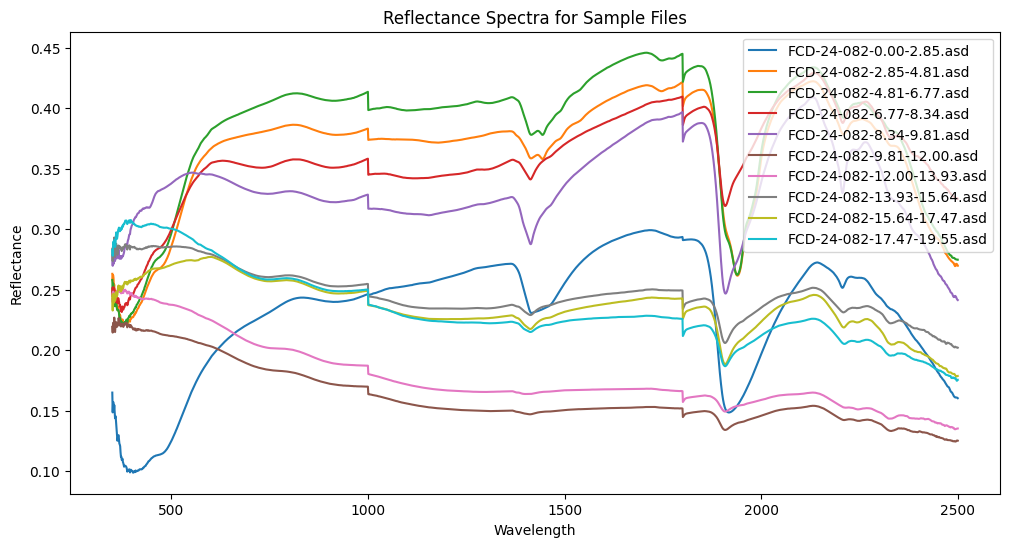

In [251]:
sample_files = data['file_name'].unique()[:10]
plt.figure(figsize=(12, 6))
for file in sample_files:
    subset = data[data['file_name'] == file]
    plt.plot(subset['wavelength'], subset['reflect'], label=file)
plt.xlabel("Wavelength")
plt.ylabel("Reflectance")
plt.title("Reflectance Spectra for Sample Files")
plt.legend()
plt.show()

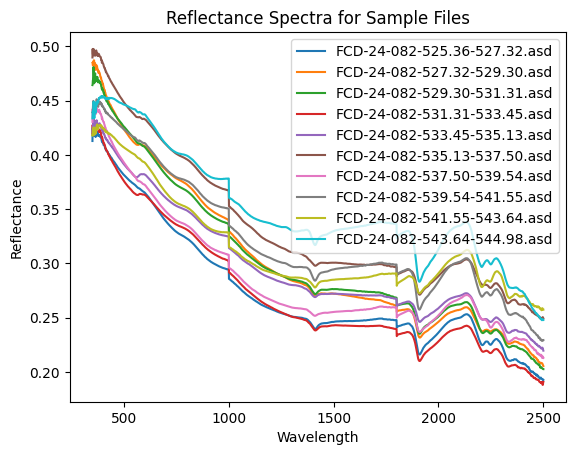

In [252]:
sample_files = data['file_name'].unique()[-10:]
for file in sample_files:
    subset = data[data['file_name'] == file]
    plt.plot(subset['wavelength'], subset['reflect'], label=file)
plt.xlabel("Wavelength")
plt.ylabel("Reflectance")
plt.title("Reflectance Spectra for Sample Files")
plt.legend()
plt.show()

 Keep only Wavelength and Reflectance values

In [253]:
# Load the Sorted Data
sorted_csv_path = "/content/sorted_reflectance_data.csv"
asd_df = pd.read_csv(sorted_csv_path)

In [254]:
# Drop Remove Target Count & Reference Count Columns
columns_to_drop = ["tgt_count", "ref_count"]
asd_df = asd_df.drop(columns=[col for col in columns_to_drop if col in asd_df.columns], errors="ignore")

In [255]:
# Save the Optimized Data
optimized_csv_path = "reflectance_data.csv"
asd_df.to_csv(optimized_csv_path, index=False)

## 1.3 Continuum Correction

In [256]:
import numpy as np
from scipy import spatial, interpolate

def calc_continuum(spectrum):
    """
    Perform continuum correction on a given spectrum.
    :param spectrum: DataFrame containing 'wavelength' and 'reflect'.
    :return: Continuum-corrected reflectance as a numpy array.
    """
    spec_wavelength = spectrum["wavelength"].values
    spec_reflect = spectrum["reflect"].values

    # Construct points for the convex hull
    points = np.column_stack((
        np.append(np.insert(spec_wavelength, 0, spec_wavelength[0]), spec_wavelength[-1]),
        np.append(np.insert(spec_reflect, 0, 0), 0)
    ))

    # Handle NaNs and infinities
    points = np.nan_to_num(points, nan=0, posinf=1, neginf=0)

    # Calculate the convex hull
    try:
        hull = spatial.ConvexHull(points)
    except ValueError:
        print("Unable to calculate convex hull.")
        return None

    # Extract hull vertices and sort by wavelength
    vertices = sorted(hull.vertices)
    vertices = vertices[1:-1]  # Remove the dummy points added at the edges

    # Handle cases where vertex indices exceed bounds
    # Subtract 1 from vertices to align with 0-based indexing
    vertices = np.where(vertices == len(spec_wavelength), len(spec_wavelength) -1 , vertices) #changed to len(spec_wavelength) - 1
    vertices = vertices - 1  # Subtract 1 to adjust for 0-based indexing


    # Interpolate the hull
    hull_points = spec_reflect[vertices]
    wvl = spec_wavelength[vertices]
    continuum_interpolator = interpolate.interp1d(
        wvl, hull_points, bounds_error=False, fill_value="extrapolate"
    )
    continuum = continuum_interpolator(spec_wavelength)

    # Perform continuum correction
    return spec_reflect / continuum

In [257]:
# Load dataset
data = pd.read_csv("/content/reflectance_data.csv")

# Initialize an empty list to store corrected spectra
corrected_spectra = []

# Process each file individually
for file_name in data['file_name'].unique():
    subset = data[data['file_name'] == file_name]

    # Perform continuum correction
    corrected_reflect = calc_continuum(subset)

    # Add the corrected reflectance to the subset
    subset["continuum_corrected"] = corrected_reflect
    corrected_spectra.append(subset)

# Combine all corrected spectra
corrected_data = pd.concat(corrected_spectra, ignore_index=True)

# Save the corrected dataset
corrected_data.to_csv("continuum_corrected_reflectance_data.csv", index=False)
print("Continuum-corrected reflectance data saved.")

<ipython-input-257-3f112491009c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["continuum_corrected"] = corrected_reflect
<ipython-input-257-3f112491009c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["continuum_corrected"] = corrected_reflect
<ipython-input-257-3f112491009c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Continuum-corrected reflectance data saved.


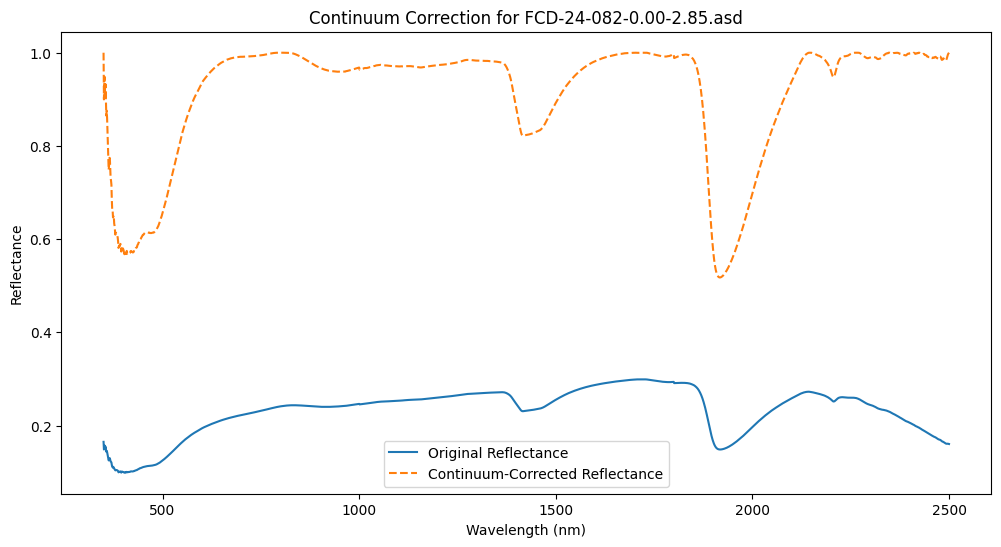

In [258]:
# Select a sample file
sample_file = data['file_name'].unique()[0]
subset = data[data['file_name'] == sample_file]

# Perform continuum correction
corrected_reflect = calc_continuum(subset)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(subset["wavelength"], subset["reflect"], label="Original Reflectance")
plt.plot(subset["wavelength"], corrected_reflect, label="Continuum-Corrected Reflectance", linestyle="--")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title(f"Continuum Correction for {sample_file}")
plt.legend()
plt.show()

## 1.4 Reshape to wide format

In [259]:
# Reshape to wide format
corrected_data = pd.read_csv('/content/continuum_corrected_reflectance_data.csv')
wide_format_data = corrected_data.pivot(index='file_name', columns='wavelength', values='continuum_corrected')
wide_format_data.to_csv('wide_format_reflectance_data.csv')
print("Wide format data saved.")


Wide format data saved.


In [260]:
# Load the wide format data
wide_format_data = pd.read_csv('/content/wide_format_reflectance_data.csv')

# Print the wide format data
wide_format_data


file_name  350.0     351.0     352.0     353.0  \
0        FCD-24-082-0.00-2.85.asd    1.0  0.899843  0.947418  0.948118   
1    FCD-24-082-100.76-103.72.asd    1.0  0.986522  0.996528  1.000000   
2    FCD-24-082-103.72-105.05.asd    1.0  0.983450  0.996521  1.000000   
3    FCD-24-082-105.05-106.71.asd    1.0  0.998844  1.000000  0.997056   
4    FCD-24-082-106.71-108.71.asd    1.0  0.983395  0.988952  0.991483   
5    FCD-24-082-108.71-110.80.asd    1.0  0.983579  0.991411  0.994893   
6    FCD-24-082-110.80-112.84.asd    1.0  0.984158  0.991699  0.996196   
7    FCD-24-082-112.84-114.77.asd    1.0  0.983731  0.995701  0.996787   
8    FCD-24-082-114.77-116.74.asd    1.0  0.995503  0.998038  0.999440   
9    FCD-24-082-116.74-118.79.asd    1.0  0.987211  0.997573  1.000000   
10   FCD-24-082-118.79-120.56.asd    1.0  0.986344  1.000000  1.000000   
11     FCD-24-082-12.00-13.93.asd    1.0  0.976516  1.000000  0.997676   
12   FCD-24-082-120.56-122.80.asd    1.0  0.989287  0.998623  1.000000   
13   FCD-24-082-122.80-124.93.asd    1.0  0.974054  0.999097  1.000000   
14   FCD-24-082-124.93-126.93.asd    1.0  0.990463  0.989625  0.995908   
15   FCD-24-082-126.93-128.89.asd    1.0  0.992176  0.998795  0.998331   
16   FCD-24-082-128.89-131.18.asd    1.0  0.985290  0.999233  1.000000   
17     FCD-24-082-13.93-15.64.asd    1.0  0.957829  0.990712  0.983817   
18   FCD-24-082-131.18-133.17.asd    1.0  0.977598  0.984362  0.994544   
19   FCD-24-082-133.17-133.76.asd    1.0  0.979117  0.987335  0.997008   
20   FCD-24-082-133.76-134.26.asd    1.0  0.976732  0.993599  1.000000   
21   FCD-24-082-134.26-136.20.asd    1.0  0.984331  0.998133  1.000000   
22   FCD-24-082-136.20-138.23.asd    1.0  0.983649  0.992716  0.999650   
23   FCD-24-082-138.23-140.22.asd    1.0  0.974981  0.989492  1.000000   
24   FCD-24-082-140.22-142.21.asd    1.0  0.983677  0.989209  0.996157   
25   FCD-24-082-142.21-143.38.asd    1.0  0.988421  1.000000  1.000000   
26   FCD-24-082-143.38-144.62.asd    1.0  0.982812  0.989662  0.991187   
27   FCD-24-082-144.62-146.19.asd    1.0  0.981613  1.000000  1.000000   
28   FCD-24-082-146.19-148.06.asd    1.0  0.975829  1.000000  1.000000   
29   FCD-24-082-148.06-149.86.asd    1.0  0.976072  0.996849  1.000000   
30   FCD-24-082-149.86-152.09.asd    1.0  0.969986  0.997148  1.000000   
31     FCD-24-082-15.64-17.47.asd    1.0  0.947432  0.995177  0.999821   
32   FCD-24-082-152.09-154.20.asd    1.0  0.957412  0.982026  0.983009   
33   FCD-24-082-154.20-156.18.asd    1.0  0.972878  1.000000  0.993452   
34   FCD-24-082-156.18-158.18.asd    1.0  0.980971  0.997859  1.000000   
35   FCD-24-082-158.18-159.42.asd    1.0  0.966884  0.994735  1.000000   
36   FCD-24-082-159.42-161.68.asd    1.0  0.986320  1.000000  1.000000   
37   FCD-24-082-161.68-163.96.asd    1.0  0.961295  0.982176  0.990379   
38   FCD-24-082-163.96-166.95.asd    1.0  0.973444  1.000000  1.000000   
39   FCD-24-082-166.95-168.42.asd    1.0  0.981959  0.988040  0.993109   
40   FCD-24-082-168.42-168.92.asd    1.0  0.993187  0.984385  0.983451   
41   FCD-24-082-168.92-170.82.asd    1.0  0.992887  1.000000  0.990276   
42     FCD-24-082-17.47-19.55.asd    1.0  0.975221  0.997433  1.000000   
43   FCD-24-082-170.82-172.52.asd    1.0  0.962352  0.973038  0.979898   
44   FCD-24-082-172.52-174.43.asd    1.0  0.969486  0.986745  0.992095   
45   FCD-24-082-174.43-176.50.asd    1.0  0.978077  1.000000  1.000000   
46   FCD-24-082-176.50-178.60.asd    1.0  0.967375  0.994614  1.000000   
47   FCD-24-082-178.60-180.65.asd    1.0  0.981309  0.992789  0.992970   
48   FCD-24-082-180.65-182.66.asd    1.0  0.993321  1.000000  0.981888   
49   FCD-24-082-182.66-184.98.asd    1.0  0.995735  1.000000  0.988375   
50   FCD-24-082-184.98-186.77.asd    1.0  0.993332  1.000000  0.997009   
51   FCD-24-082-186.77-188.83.asd    1.0  0.987358  0.999591  0.996253   
52   FCD-24-082-188.83-189.83.asd    1.0  0.992138  0.997857  1.000000   
53   FCD-24-082-189.83-190.9

In [261]:
wide_format_data.describe()

350.0       351.0       352.0       353.0       354.0       355.0  \
count  288.0  288.000000  288.000000  288.000000  288.000000  288.000000   
mean     1.0    0.977710    0.995410    0.994501    0.980866    0.994889   
std      0.0    0.013619    0.006544    0.006932    0.011891    0.007732   
min      1.0    0.899843    0.947418    0.948118    0.904196    0.932516   
25%      1.0    0.969266    0.993014    0.990862    0.973811    0.991672   
50%      1.0    0.978456    0.997901    0.996791    0.982554    0.998092   
75%      1.0    0.986479    1.000000    1.000000    0.989603    1.000000   
max      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   

            356.0       357.0       358.0       359.0  ...      2491.0  \
count  288.000000  288.000000  288.000000  288.000000  ...  288.000000   
mean     0.981783    0.972667    0.981441    0.984606  ...    0.987280   
std      0.011526    0.014920    0.013386    0.013906  ...    0.008293   
min      0.893845    0.865102    0.875571    0.860158  ...    0.956530   
25%      0.976735    0.965212    0.974962    0.978024  ...    0.982582   
50%      0.982503    0.974273    0.983872    0.987120  ...    0.988976   
75%      0.988910    0.982978    0.989640    0.993245  ...    0.993294   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

           2492.0      2493.0      2494.0      2495.0      2496.0      2497.0  \
count  288.000000  288.000000  288.000000  288.000000  288.000000  288.000000   
mean     0.988365    0.989219    0.990287    0.991279    0.992665    0.994481   
std      0.007642    0.007112    0.006459    0.005931    0.005157    0.004130   
min      0.960540    0.962578    0.966363    0.970340    0.975963    0.982131   
25%      0.983995    0.985193    0.986417    0.987947    0.989556    0.991688   
50%      0.989883    0.990819    0.991529    0.992549    0.993270    0.995010   
75%      0.994165    0.994661    0.995137    0.995780    0.996511    0.998099   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           2498.0      2499.0        2500.0  
count  288.000000  288.000000  2.880000e+02  
mean     0.996142    0.998287  1.000000e+00  
std      0.003113    0.001150  2.270178e-17  
min      0.986004    0.994619  1.000000e+00  
25%      0.994060    0.997468  1.000000e+00  
50%      0.996538    0.998463  1.000000e+00  
75%      0.998808    0.999156  1.000000e+00  
max      1.000000    1.000000  1.000000e+00  

[8 rows x 2151 columns]

In [262]:
# Compute Mean and Standard Deviation for Each Wavelength
wavelength_columns = wide_format_data.columns[1:]  # Exclude "file_name" column
mean_reflectance = wide_format_data[wavelength_columns].mean()
std_reflectance = wide_format_data[wavelength_columns].std()

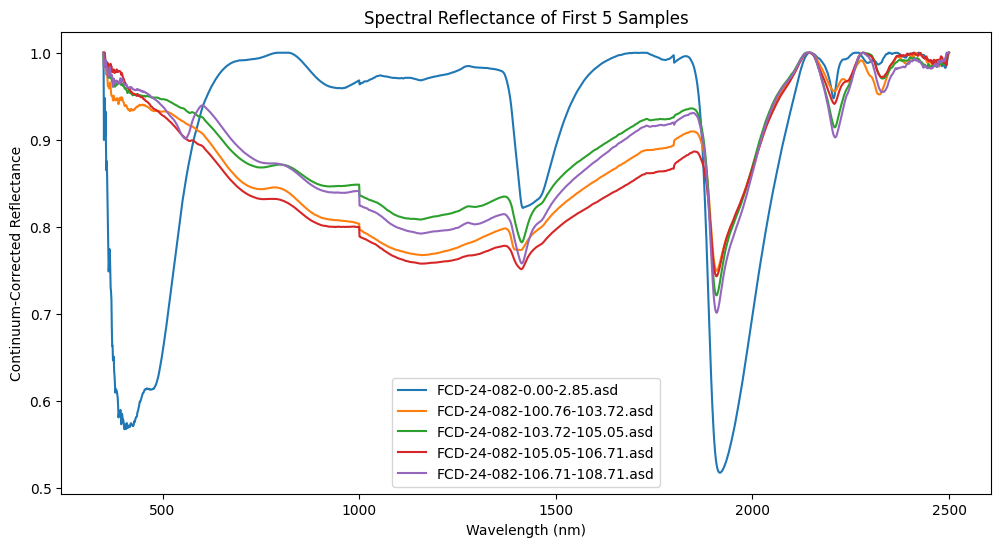

In [263]:
# Visualize Reflectance Distribution (First 5 Samples)
plt.figure(figsize=(12, 6))
for i in range(5):
    sample_name = wide_format_data.iloc[i, 0]  # Extract file_name
    plt.plot(wavelength_columns.astype(float), wide_format_data.iloc[i, 1:], label=sample_name)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Continuum-Corrected Reflectance")
plt.title("Spectral Reflectance of First 5 Samples")
plt.legend()
plt.show()

In [264]:
# Extract reflectance values
wavelength_columns = wide_format_data.columns[1:]

# Define number of subplots (e.g., split into 10 groups)
num_plots = 10
wavelength_groups = np.array_split(wavelength_columns, num_plots)

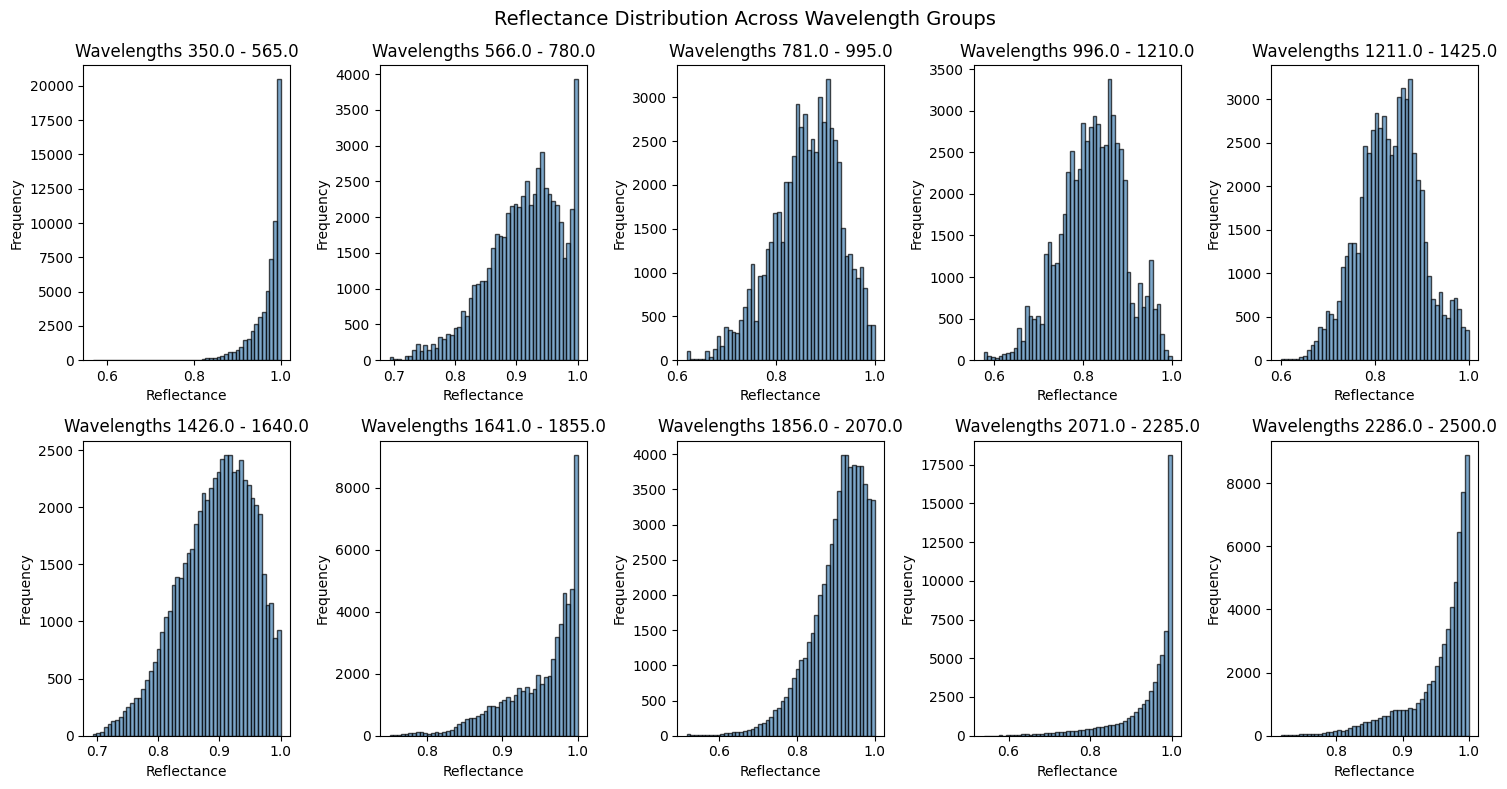

In [265]:
# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns
axes = axes.flatten()

for i, wavelengths in enumerate(wavelength_groups):
    ax = axes[i]
    reflectance_values = wide_format_data[wavelengths].values.flatten()  # Flatten into 1D array
    ax.hist(reflectance_values, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Wavelengths {wavelengths[0]} - {wavelengths[-1]}")
    ax.set_xlabel("Reflectance")
    ax.set_ylabel("Frequency")

plt.suptitle("Reflectance Distribution Across Wavelength Groups", fontsize=14)
plt.tight_layout()
plt.show()

# 2. Excel Data Description

## 2.1 Data Over & Drop complete missing columns

In [266]:
pd.set_option("display.max_rows", None)

# Load excel file
file_path = "/content/FCD-24-082_Aisiris data_110824 FCD-24-082.csv" # Remember to upload Excel file
df = pd.read_csv(file_path)

print("column", df.columns.tolist())
print("number_of_Sample:", len(df))

column ['Spectrum', 'FileName', 'ProjectPath', 'Company', 'Country', 'Region', 'Project', 'OperatorName', 'DispatchID', 'LabJobNumber', 'PONumber', 'POContact', 'CostCode', 'SampleID', 'HoleID', 'DepthFrom', 'DepthTo', 'CollarEast', 'CollarNorth', 'Dip', 'Azimuth', 'XEast', 'YNorth', 'ZRel', 'SpectromType', 'SpectromNo', 'SampleType', 'OrigSampleType', 'FeatureType', 'Integration', 'Comment', 'ImportDate', 'SpectrumID', 'Geology', 'SWIRMinerals', 'SWIRMin_nowt', 'aiMineral1', 'aiMineral2', 'aiMineral3', 'aiMineral4', 'aiMineral5', 'aiMineral6', 'VNIRMinerals', 'Reflectance', 'QaQc_Reflect', 'SWIRNoise', 'QaQc_Noise', 'AvgDFeature', 'QA_AvgDFeature', 'QaQc_Quality', 'QaQc_Water', 'WhiteMica_SC', 'Chlorite_SC', 'Carbonate_SC', 'Biotite_SC', 'Epidote_SC', 'Kaolinite_SC', 'Dickite_SC', 'Halloysite_SC', 'Amphibole_SC', 'Talc_SC', 'Serpentine_SC', 'Montmor_SC', 'Nontronite_SC', 'Saponite_SC', 'Zeolite_SC', 'Palygor_SC', 'Alunite_SC', 'CaAlunite_SC', 'Jarosite_SC', 'Gypsum_SC', 'Pyrophyllite_

In [267]:
# Check miss values
missing_values = df.isnull().sum()
missing_df = missing_values[missing_values > 0].reset_index()
missing_df.columns = ["Column", "Missing Count"]
display(missing_df)

Column  Missing Count
0       DispatchID            288
1     LabJobNumber            288
2         PONumber            288
3        POContact            288
4         CostCode            288
5       CollarEast            288
6      CollarNorth            288
7              Dip            288
8          Azimuth            288
9            XEast            288
10          YNorth            288
11            ZRel            288
12         Comment            288
13      aiMineral2              2
14      aiMineral3             21
15      aiMineral4            118
16      aiMineral5            228
17      aiMineral6            281
18  QA_AvgDFeature            288
19   Jarosite_vnir            288
20     FeCarb_vnir            288
21        Hem_vnir            285
22      Goeth_vnir            287
23      CuMin_vnir            288
24        Chl_vnir             26
25      Tourm_vnir            286
26       Amph_vnir            288
27       Epid_vnir            288
28      Wav_WtMica            200
29     Type_WtMica            200
30       XT_WtMica            208
31    Wav_Chlorite            170
32   Type_Chlorite            170
33     Wav_Alunite            288
34     Int_Alunite            288
35    Type_Alunite            288
36         wavCarb            287
37       Type_Carb            287
38         wavAmph            288
39       Type_Amph            288
40    Type_Biotite            288
41       Int_Topaz            288
42    XT_Kaolinite            257
43     XT_Kaol2180            257
44     XT_Kaol2160            257
45        Wav_Main              1
46          D_Main              1
47        Wav_AlOH              1
48          D_AlOH              1
49         Wd_AlOH              1
50     Wav_AlOHAll              1
51       D_AlOHAll              1
52      Wd_AlOHAll              1
53        Wav_FeOH            166
54          D_FeOH            166
55         Wd_FeOH            169
56      Wav_MgOHCb              1
57        D_MgOHCb              1
58       Wd_MgOHCb              1
59     RelSmectite             53
60      Wav_Ep1550            288
61        D_Ep1550            288
62     Wav_FeOxide            284
63       D_FeOxide            284
64     FIntFeOxide            284

Wav_FeOxide, D_feOxide, FIntFeOxide is only related to iron-related minerals, there are only four sample in the file: goethite & hematite in VNIRMinerals, so don't delete.
Hem_vnir is related to hematite.
Goeth_vnir is related to geothite.
Tourm_vnir is related to tourmaline.
wavCarb and Type_Carb is related to carbonate in aiMineral1.


In [268]:
# Display basic statistics for numerical columns
print(df.describe(include="all").transpose().to_string())

# Display data types of each column
print("\nData Types:")
display(df.dtypes)

                 count unique                                    top freq         mean         std          min          25%          50%          75%          max
Spectrum           288    288               FCD-24-082-0.00-2.85.asd    1          NaN         NaN          NaN          NaN          NaN          NaN          NaN
FileName           288    288               FCD-24-082-0.00-2.85.asd    1          NaN         NaN          NaN          NaN          NaN          NaN          NaN
ProjectPath        288      1         copperbankcorp.usa.az.cu_creek  288          NaN         NaN          NaN          NaN          NaN          NaN          NaN
Company            288      1                         copperbankcorp  288          NaN         NaN          NaN          NaN          NaN          NaN          NaN
Country            288      1                                    usa  288          NaN         NaN          NaN          NaN          NaN          NaN          NaN
Region          

Spectrum            object
FileName            object
ProjectPath         object
Company             object
Country             object
Region              object
Project             object
OperatorName        object
DispatchID         float64
LabJobNumber       float64
PONumber           float64
POContact          float64
CostCode           float64
SampleID            object
HoleID              object
DepthFrom          float64
DepthTo            float64
CollarEast         float64
CollarNorth        float64
Dip                float64
Azimuth            float64
XEast              float64
YNorth             float64
ZRel               float64
SpectromType        object
SpectromNo           int64
SampleType          object
OrigSampleType      object
FeatureType         object
Integration          int64
Comment            float64
ImportDate          object
SpectrumID          object
Geology             object
SWIRMinerals        object
SWIRMin_nowt        object
aiMineral1          object
aiMineral2          object
aiMineral3          object
aiMineral4          object
aiMineral5          object
aiMineral6          object
VNIRMinerals        object
Reflectance        float64
QaQc_Reflect        object
SWIRNoise          float64
QaQc_Noise          object
AvgDFeature        float64
QA_AvgDFeature     float64
QaQc_Quality        object
QaQc_Water          object
WhiteMica_SC         int64
Chlorite_SC          int64
Carbonate_SC         int64
Biotite_SC           int64
Epidote_SC           int64
Kaolinite_SC         int64
Dickite_SC           int64
Halloysite_SC        int64
Amphibole_SC         int64
Talc_SC              int64
Serpentine_SC        int64
Montmor_SC           int64
Nontronite_SC        int64
Saponite_SC          int64
Zeolite_SC           int64
Palygor_SC           int64
Alunite_SC           int64
CaAlunite_SC         int64
Jarosite_SC          int64
Gypsum_SC            int64
Pyrophyllite_SC      int64
Diaspore_SC          int64
Topaz_SC             int64
Zunyite_SC           int64
Tourm_SC             int64
Sudoite_SC           int64
Prehnite_SC          int64
Pumpell_SC           int64
Zoisite_SC           int64
Ottrelite_SC         int64
NH4WtMica_SC         int64
NH4Min_SC            int64
Malachite_SC         int64
Antlerite_SC         int64
Azurite_SC           int64
Chryscll_SC          int64
Gibbsite_SC          int64
Boehmite_SC          int64
Apoph_SC             int64
Chondrt_SC           int64
Brucite_SC           int64
Scorodite_SC         int64
Beryl_SC             int64
Water_silica_SC      int64
Jarosite_vnir      float64
FeCarb_vnir        float64
Hem_vnir           float64
Goeth_vnir         float64
CuMin_vnir         float64
Chl_vnir           float64
Tourm_vnir         float64
Amph_vnir          float64
Epid_vnir          float64
Wav_WtMica         float64
Type_WtMica         object
XT_WtMica          float64
Wav_Chlorite       float64
Type_Chlorite       object
Wav_Alunite        float64
Int_Alunite        float64
Type_Alunite       float64
wavCarb            float64
Type_Carb           object
wavAmph            float64
Type_Amph          float64
Type_Biotite       float64
Int_Topaz          float64
XT_Kaolinite        object
XT_Kaol2180        float64
XT_Kaol2160        float64
KaDiWtM            float64
Slope2160          float64
Wav_Main           float64
D_Main             float64
Wav_AlOH           float64
D_AlOH             float64
Wd_AlOH            float64
Wav_AlOHAll        float64
D_AlOHAll          float64
Wd_AlOHAll         float64
Wav_FeOH           float64
D_FeOH             float64
Wd_FeOH            float64
Wav_MgOHCb         float64
D_MgOHCb           float64
Wd_MgOHCb          float64
RelSmectite        float64
Wav_OH1400         float64
D_OH1400           float64
Wd_OH1400          float64
Wav_Ep1550         float64
D_Ep1550           float64
Wav_H2O            float64
D_H2O              float64
FeSlope            float64
Int_FeOxide        float64
Wav_FeOxide        float64
D_Fe

In [269]:
# Delete irrelevant and complete missing columns
columns_to_drop = ['ProjectPath', 'Company', 'Country', 'Region', 'Project', 'OperatorName', 'DispatchID',
                   'LabJobNumber', 'PONumber', 'POContact', 'CostCode', 'SampleID', 'HoleID',
                   'FeatureType', 'SpectromType', 'SpectromNo', 'SampleType', 'OrigSampleType','Integration',
                   'Comment', 'ImportDate', 'SpectrumID', 'Geology','CollarEast',
                   'CollarNorth', 'Dip', 'Azimuth', 'XEast', 'YNorth', 'ZRel', 'QA_AvgDFeature','Jarosite_vnir',
                   'FeCarb_vnir', 'CuMin_vnir', 'Amph_vnir', 'Epid_vnir',
                   'Wav_Alunite', 'Int_Alunite', 'Type_Alunite','wavAmph','Type_Amph',
                   'Type_Biotite', 'Int_Topaz', 'Wav_Ep1550', 'D_Ep1550']
df_cleaned = df.drop(columns=columns_to_drop, errors="ignore")

In [270]:
# Save the cleaned DataFrame to a CSV file
df_cleaned.to_csv('cleaned_df.csv')

In [271]:
# Display full descriptive statistics table for cleaned file
print(df_cleaned.describe(include="all").transpose().to_string())

                 count unique                                    top freq         mean         std          min          25%          50%          75%          max
Spectrum           288    288               FCD-24-082-0.00-2.85.asd    1          NaN         NaN          NaN          NaN          NaN          NaN          NaN
FileName           288    288               FCD-24-082-0.00-2.85.asd    1          NaN         NaN          NaN          NaN          NaN          NaN          NaN
DepthFrom        288.0    NaN                                    NaN  NaN   270.717569  157.100863          0.0      135.715       272.12     405.4325       543.64
DepthTo          288.0    NaN                                    NaN  NaN   272.609861   157.11085         2.85     137.7225      274.145     406.3625       544.98
SWIRMinerals       288    176  white mica:85+chlorite:10+carbonate:5   21          NaN         NaN          NaN          NaN          NaN          NaN          NaN
SWIRMin_nowt    

In [272]:
# Save the descriptive statistics table to a CSV file
description_table = df_cleaned.describe(include="all").transpose()
description_table.to_csv('description_table.csv')

In [273]:
# Calculate missing rate again
missing_ratio = df_cleaned.isnull().sum() / len(df)*100
missing_ratio_df = missing_ratio[missing_ratio > 0].reset_index()
missing_ratio_df.columns = ["Column", "Missing Ratio"]
display(missing_ratio_df)

Column  Missing Ratio
0      aiMineral2       0.694444
1      aiMineral3       7.291667
2      aiMineral4      40.972222
3      aiMineral5      79.166667
4      aiMineral6      97.569444
5        Hem_vnir      98.958333
6      Goeth_vnir      99.652778
7        Chl_vnir       9.027778
8      Tourm_vnir      99.305556
9      Wav_WtMica      69.444444
10    Type_WtMica      69.444444
11      XT_WtMica      72.222222
12   Wav_Chlorite      59.027778
13  Type_Chlorite      59.027778
14        wavCarb      99.652778
15      Type_Carb      99.652778
16   XT_Kaolinite      89.236111
17    XT_Kaol2180      89.236111
18    XT_Kaol2160      89.236111
19       Wav_Main       0.347222
20         D_Main       0.347222
21       Wav_AlOH       0.347222
22         D_AlOH       0.347222
23        Wd_AlOH       0.347222
24    Wav_AlOHAll       0.347222
25      D_AlOHAll       0.347222
26     Wd_AlOHAll       0.347222
27       Wav_FeOH      57.638889
28         D_FeOH      57.638889
29        Wd_FeOH      58.680556
30     Wav_MgOHCb       0.347222
31       D_MgOHCb       0.347222
32      Wd_MgOHCb       0.347222
33    RelSmectite      18.402778
34    Wav_FeOxide      98.611111
35      D_FeOxide      98.611111
36    FIntFeOxide      98.611111

## 2.2 Merge data

In [274]:
# Load classification file
file_path = "/content/cleaned_df.csv"
df_main = pd.read_csv(file_path)

In [275]:
# Load spectral file
file_path = "/content/wide_format_reflectance_data.csv"
df_spectral = pd.read_csv(file_path)


In [276]:
print("df_main columns:", df_main.columns.tolist())
print("df_spectral columns:", df_spectral.columns.tolist())

df_main columns: ['Unnamed: 0', 'Spectrum', 'FileName', 'DepthFrom', 'DepthTo', 'SWIRMinerals', 'SWIRMin_nowt', 'aiMineral1', 'aiMineral2', 'aiMineral3', 'aiMineral4', 'aiMineral5', 'aiMineral6', 'VNIRMinerals', 'Reflectance', 'QaQc_Reflect', 'SWIRNoise', 'QaQc_Noise', 'AvgDFeature', 'QaQc_Quality', 'QaQc_Water', 'WhiteMica_SC', 'Chlorite_SC', 'Carbonate_SC', 'Biotite_SC', 'Epidote_SC', 'Kaolinite_SC', 'Dickite_SC', 'Halloysite_SC', 'Amphibole_SC', 'Talc_SC', 'Serpentine_SC', 'Montmor_SC', 'Nontronite_SC', 'Saponite_SC', 'Zeolite_SC', 'Palygor_SC', 'Alunite_SC', 'CaAlunite_SC', 'Jarosite_SC', 'Gypsum_SC', 'Pyrophyllite_SC', 'Diaspore_SC', 'Topaz_SC', 'Zunyite_SC', 'Tourm_SC', 'Sudoite_SC', 'Prehnite_SC', 'Pumpell_SC', 'Zoisite_SC', 'Ottrelite_SC', 'NH4WtMica_SC', 'NH4Min_SC', 'Malachite_SC', 'Antlerite_SC', 'Azurite_SC', 'Chryscll_SC', 'Gibbsite_SC', 'Boehmite_SC', 'Apoph_SC', 'Chondrt_SC', 'Brucite_SC', 'Scorodite_SC', 'Beryl_SC', 'Water_silica_SC', 'Hem_vnir', 'Goeth_vnir', 'Chl_vnir

In [277]:
# Standardize Column Names (Make lowercase & consistent)
df_spectral.rename(columns={"file_name": "FileName"}, inplace=True)  # Match metadata
df_main.rename(columns={"FileName": "FileName"}, inplace=True)  # Ensure consistency

In [278]:
#  Verify column names
print("📌 Spectral Data Columns:", df_spectral.columns)
print("📌 Metadata Columns:", df_main.columns)

📌 Spectral Data Columns: Index(['FileName', '350.0', '351.0', '352.0', '353.0', '354.0', '355.0',
       '356.0', '357.0', '358.0',
       ...
       '2491.0', '2492.0', '2493.0', '2494.0', '2495.0', '2496.0', '2497.0',
       '2498.0', '2499.0', '2500.0'],
      dtype='object', length=2152)
📌 Metadata Columns: Index(['Unnamed: 0', 'Spectrum', 'FileName', 'DepthFrom', 'DepthTo',
       'SWIRMinerals', 'SWIRMin_nowt', 'aiMineral1', 'aiMineral2',
       'aiMineral3',
       ...
       'Wav_OH1400', 'D_OH1400', 'Wd_OH1400', 'Wav_H2O', 'D_H2O', 'FeSlope',
       'Int_FeOxide', 'Wav_FeOxide', 'D_FeOxide', 'FIntFeOxide'],
      dtype='object', length=106)


In [279]:
# Merge Spectral Data with Metadata
merged_df = pd.merge(df_main, df_spectral, on="FileName", how="inner")

In [280]:
# Save the Merged Dataset
merged_path = "merged_spectral_metadata.csv"
merged_df.to_csv(merged_path, index=False)

print(f"✅ Merged dataset saved as {merged_path}")

✅ Merged dataset saved as merged_spectral_metadata.csv


## 2.3 Handle Missing Values

In [281]:
# Load the Merged Dataset
merged_path = "merged_spectral_metadata.csv"
df = pd.read_csv(merged_path)

<ipython-input-281-b18b7f5094a9>:3: DtypeWarning: Columns (12,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(merged_path)


In [282]:
df

Unnamed: 0                      Spectrum                      FileName  \
0             0      FCD-24-082-0.00-2.85.asd      FCD-24-082-0.00-2.85.asd   
1             1  FCD-24-082-100.76-103.72.asd  FCD-24-082-100.76-103.72.asd   
2             2  FCD-24-082-103.72-105.05.asd  FCD-24-082-103.72-105.05.asd   
3             3  FCD-24-082-105.05-106.71.asd  FCD-24-082-105.05-106.71.asd   
4             4  FCD-24-082-106.71-108.71.asd  FCD-24-082-106.71-108.71.asd   
5             5  FCD-24-082-108.71-110.80.asd  FCD-24-082-108.71-110.80.asd   
6             6  FCD-24-082-110.80-112.84.asd  FCD-24-082-110.80-112.84.asd   
7             7  FCD-24-082-112.84-114.77.asd  FCD-24-082-112.84-114.77.asd   
8             8  FCD-24-082-114.77-116.74.asd  FCD-24-082-114.77-116.74.asd   
9             9  FCD-24-082-116.74-118.79.asd  FCD-24-082-116.74-118.79.asd   
10           10  FCD-24-082-118.79-120.56.asd  FCD-24-082-118.79-120.56.asd   
11           11    FCD-24-082-12.00-13.93.asd    FCD-24-082-12.00-13.93.asd   
12           12  FCD-24-082-120.56-122.80.asd  FCD-24-082-120.56-122.80.asd   
13           13  FCD-24-082-122.80-124.93.asd  FCD-24-082-122.80-124.93.asd   
14           14  FCD-24-082-124.93-126.93.asd  FCD-24-082-124.93-126.93.asd   
15           15  FCD-24-082-126.93-128.89.asd  FCD-24-082-126.93-128.89.asd   
16           16  FCD-24-082-128.89-131.18.asd  FCD-24-082-128.89-131.18.asd   
17           17    FCD-24-082-13.93-15.64.asd    FCD-24-082-13.93-15.64.asd   
18           18  FCD-24-082-131.18-133.17.asd  FCD-24-082-131.18-133.17.asd   
19           19  FCD-24-082-133.17-133.76.asd  FCD-24-082-133.17-133.76.asd   
20           20  FCD-24-082-133.76-134.26.asd  FCD-24-082-133.76-134.26.asd   
21           21  FCD-24-082-134.26-136.20.asd  FCD-24-082-134.26-136.20.asd   
22           22  FCD-24-082-136.20-138.23.asd  FCD-24-082-136.20-138.23.asd   
23           23  FCD-24-082-138.23-140.22.asd  FCD-24-082-138.23-140.22.asd   
24           24  FCD-24-082-140.22-142.21.asd  FCD-24-082-140.22-142.21.asd   
25           25  FCD-24-082-142.21-143.38.asd  FCD-24-082-142.21-143.38.asd   
26           26  FCD-24-082-143.38-144.62.asd  FCD-24-082-143.38-144.62.asd   
27           27  FCD-24-082-144.62-146.19.asd  FCD-24-082-144.62-146.19.asd   
28           28  FCD-24-082-146.19-148.06.asd  FCD-24-082-146.19-148.06.asd   
29           29  FCD-24-082-148.06-149.86.asd  FCD-24-082-148.06-149.86.asd   
30           30  FCD-24-082-149.86-152.09.asd  FCD-24-082-149.86-152.09.asd   
31           31    FCD-24-082-15.64-17.47.asd    FCD-24-082-15.64-17.47.asd   
32           32  FCD-24-082-152.09-154.20.asd  FCD-24-082-152.09-154.20.asd   
33           33  FCD-24-082-154.20-156.18.asd  FCD-24-082-154.20-156.18.asd   
34           34  FCD-24-082-156.18-158.18.asd  FCD-24-082-156.18-158.18.asd   
35           35  FCD-24-082-158.18-159.42.asd  FCD-24-082-158.18-159.42.asd   
36           36  FCD-24-082-159.42-161.68.asd  FCD-24-082-159.42-161.68.asd   
37           37  FCD-24-082-161.68-163.96.asd  FCD-24-082-161.68-163.96.asd   
38           38  FCD-24-082-163.96-166.95.asd  FCD-24-082-163.96-166.95.asd   
39           39  FCD-24-082-166.95-168.42.asd  FCD-24-082-166.95-168.42.asd   
40           40  FCD-24-082-168.42-168.92.asd  FCD-24-082-168.42-168.92.asd   
41           41  FCD-24-082-168.92-170.82.asd  FCD-24-082-168.92-170.82.asd   
42           42    FCD-24-082-17.47-19.55.asd    FCD-24-082-17.47-19.55.asd   
43           43  FCD-24-082-170.82-172.52.asd  FCD-24-082-170.82-172.52.asd   
44           44  FCD-24-082-172.52-174.43.asd  FCD-24-082-172.52-174.43.asd   
45           45  FCD-24-082-174.43-176.50.asd  FCD-24-082-174.43-176.50.asd   
46           46  FCD-24-082-176.50-178.60.asd  FCD-24-082-176.50-178.60.asd   
47           47  FCD-24-082-178.60-180.65.asd  FCD-24-082-178.60-180.65.asd   
48           48  FCD-24-082-180.65-182.66.asd  FCD-24-082-180.65-182.66.asd   
49           49  FCD-24-082-182.66-184.98.asd  FCD-24-0

In [283]:
# Check miss values
missing_values = df.isnull().sum()
missing_df = missing_values[missing_values > 0].reset_index()
missing_df.columns = ["Column", "Missing Count"]
display(missing_df)

Column  Missing Count
0      aiMineral2              2
1      aiMineral3             21
2      aiMineral4            118
3      aiMineral5            228
4      aiMineral6            281
5        Hem_vnir            285
6      Goeth_vnir            287
7        Chl_vnir             26
8      Tourm_vnir            286
9      Wav_WtMica            200
10    Type_WtMica            200
11      XT_WtMica            208
12   Wav_Chlorite            170
13  Type_Chlorite            170
14        wavCarb            287
15      Type_Carb            287
16   XT_Kaolinite            257
17    XT_Kaol2180            257
18    XT_Kaol2160            257
19       Wav_Main              1
20         D_Main              1
21       Wav_AlOH              1
22         D_AlOH              1
23        Wd_AlOH              1
24    Wav_AlOHAll              1
25      D_AlOHAll              1
26     Wd_AlOHAll              1
27       Wav_FeOH            166
28         D_FeOH            166
29        Wd_FeOH            169
30     Wav_MgOHCb              1
31       D_MgOHCb              1
32      Wd_MgOHCb              1
33    RelSmectite             53
34    Wav_FeOxide            284
35      D_FeOxide            284
36    FIntFeOxide            284

In [284]:
# Handling Missing Values in Mineral Class Labels
aimineral_columns = ["aiMineral2", "aiMineral3", "aiMineral4", "aiMineral5", "aiMineral6"]
df[aimineral_columns] = df[aimineral_columns].replace({"": "None", "nan": "None", None: "None"}).fillna("None")

In [285]:
print(df[aimineral_columns].isna().sum())  # Should all be 0
print(df[aimineral_columns].head())  # Should contain "None" instead of NaN

aiMineral2    0
aiMineral3    0
aiMineral4    0
aiMineral5    0
aiMineral6    0
dtype: int64
   aiMineral2  aiMineral3 aiMineral4 aiMineral5 aiMineral6
0   kaolinite  nontronite       None       None       None
1   amphibole    chlorite  carbonate       None       None
2  white mica   carbonate   chlorite       None       None
3   carbonate    chlorite       None       None       None
4  white mica     biotite  carbonate   chlorite       None


In [286]:
# Handling Mineral-Specific Features (Fill numerical with 0, categorical with "Unknown")
mineral_numeric_columns = [
    "Hem_vnir", "Goeth_vnir", "Chl_vnir", "Tourm_vnir","Wav_WtMica",
    "XT_WtMica","Wav_Chlorite","wavCarb","XT_Kaol2180", "XT_Kaol2160",
    "Wav_Main", "D_Main", "Wav_FeOH", "D_FeOH", "Wd_FeOH", "Wav_MgOHCb",
    "D_MgOHCb", "Wd_MgOHCb", "RelSmectite", "Wav_FeOxide", "D_FeOxide", "FIntFeOxide"
]
df[mineral_numeric_columns] = df[mineral_numeric_columns].fillna(0)

In [287]:
mineral_categorical_columns = ["Type_WtMica", "Type_Chlorite", "Type_Carb", "XT_Kaolinite"]
df[mineral_categorical_columns] = df[mineral_categorical_columns].fillna("Unknown")

In [288]:
# Handling Special Cases (Mean Imputation for Numerical)
special_numeric_columns = ["Wav_AlOH", "D_AlOH", "Wd_AlOH", "Wav_AlOHAll", "D_AlOHAll", "Wd_AlOHAll" ]
df[special_numeric_columns] = df[special_numeric_columns].fillna(df[special_numeric_columns].mean())

In [289]:
# Save Processed Data
processed_path = "processed_merge_data.csv"
df.to_csv(processed_path, index=False)
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]
print("\n✅ Remaining Missing Values:")
print(missing_values if not missing_values.empty else "No missing values left! ")


✅ Remaining Missing Values:
No missing values left! 


## 2.4 EDA

In [290]:
df = pd.read_csv("processed_merge_data.csv")

# Display descriptive statistics table for the processed data
df.describe(include='all').transpose()

<ipython-input-290-f2edfb48f7a5>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed_merge_data.csv")


count unique                                    top freq  \
Unnamed: 0       288.0    NaN                                    NaN  NaN   
Spectrum           288    288               FCD-24-082-0.00-2.85.asd    1   
FileName           288    288               FCD-24-082-0.00-2.85.asd    1   
DepthFrom        288.0    NaN                                    NaN  NaN   
DepthTo          288.0    NaN                                    NaN  NaN   
SWIRMinerals       288    176  white mica:85+chlorite:10+carbonate:5   21   
SWIRMin_nowt       288     75          white mica+chlorite+carbonate   28   
aiMineral1         288      7                             white mica  112   
aiMineral2         286      9                             white mica   83   
aiMineral3         267      7                               chlorite  100   
aiMineral4         170      6                              carbonate   76   
aiMineral5          60      4                               chlorite   43   
aiMineral6           7      2                               chlorite    5   
VNIRMinerals       288      5                               chlorite  262   
Reflectance      288.0    NaN                                    NaN  NaN   
QaQc_Reflect       288      1                                     OK  288   
SWIRNoise        288.0    NaN                                    NaN  NaN   
QaQc_Noise         288      1                                     OK  288   
AvgDFeature      288.0    NaN                                    NaN  NaN   
QaQc_Quality       288      1                                     OK  288   
QaQc_Water         288      1                                     OK  288   
WhiteMica_SC     288.0    NaN                                    NaN  NaN   
Chlorite_SC      288.0    NaN                                    NaN  NaN   
Carbonate_SC     288.0    NaN                                    NaN  NaN   
Biotite_SC       288.0    NaN                                    NaN  NaN   
Epidote_SC       288.0    NaN                                    NaN  NaN   
Kaolinite_SC     288.0    NaN                                    NaN  NaN   
Dickite_SC       288.0    NaN                                    NaN  NaN   
Halloysite_SC    288.0    NaN                                    NaN  NaN   
Amphibole_SC     288.0    NaN                                    NaN  NaN   
Talc_SC          288.0    NaN                                    NaN  NaN   
Serpentine_SC    288.0    NaN                                    NaN  NaN   
Montmor_SC       288.0    NaN                                    NaN  NaN   
Nontronite_SC    288.0    NaN                                    NaN  NaN   
Saponite_SC      288.0    NaN                                    NaN  NaN   
Zeolite_SC       288.0    NaN                                    NaN  NaN   
Palygor_SC       288.0    NaN                                    NaN  NaN   
Alunite_SC       288.0    NaN                                    NaN  NaN   
CaAlunite_SC     288.0    NaN                                    NaN  NaN   
Jarosite_SC      288.0    NaN                                    NaN  NaN   
Gypsum_SC        288.0    NaN                                    NaN  NaN   
Pyrophyllite_SC  288.0    NaN                                    NaN  NaN   
Diaspore_SC      288.0    NaN                                    NaN  NaN   
Topaz_SC         288.0    NaN                                    NaN  NaN   
Zunyite_SC       288.0    NaN                                    NaN  NaN   
Tourm_SC         288.0    NaN                                    NaN  NaN   
Sudoite_SC       288.0    NaN                                    NaN  NaN   
Prehnite_SC      288.0    NaN                                    NaN  NaN   
Pumpell_SC       288.0    NaN                                    NaN  NaN   
Zoisite_SC       288.0    NaN                                    NaN  NaN   
Ottrelite_SC     288.0    NaN                                    NaN  NaN   
NH4WtMica_SC 

### 2.4.2 Check Class Distrubition

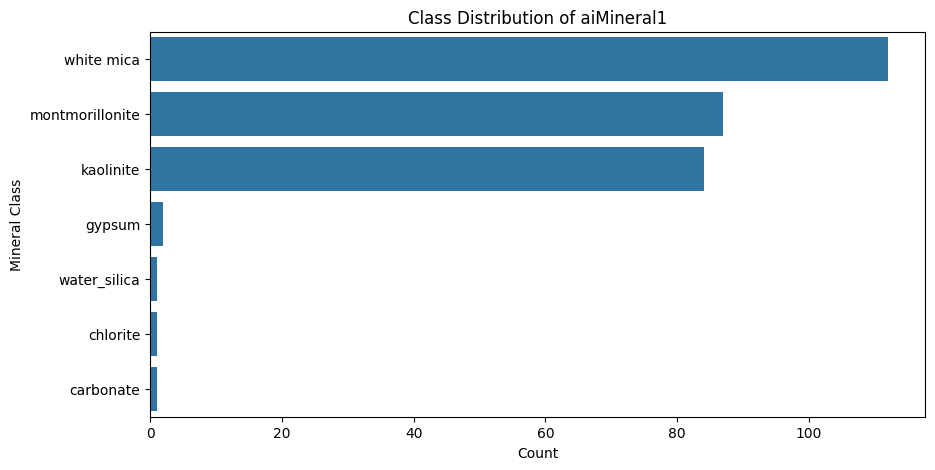

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution of aiMineral1
plt.figure(figsize=(10, 5))
sns.countplot(y=df["aiMineral1"], order=df["aiMineral1"].value_counts().index)
plt.title("Class Distribution of aiMineral1")
plt.xlabel("Count")
plt.ylabel("Mineral Class")
plt.show()

This will show how frequently each primary mineral (1-3)
appears.

<ipython-input-292-6c1015a30137>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette="viridis")
<ipython-input-292-6c1015a30137>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette="viridis")
<ipython-input-292-6c1015a30137>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette="viridis")


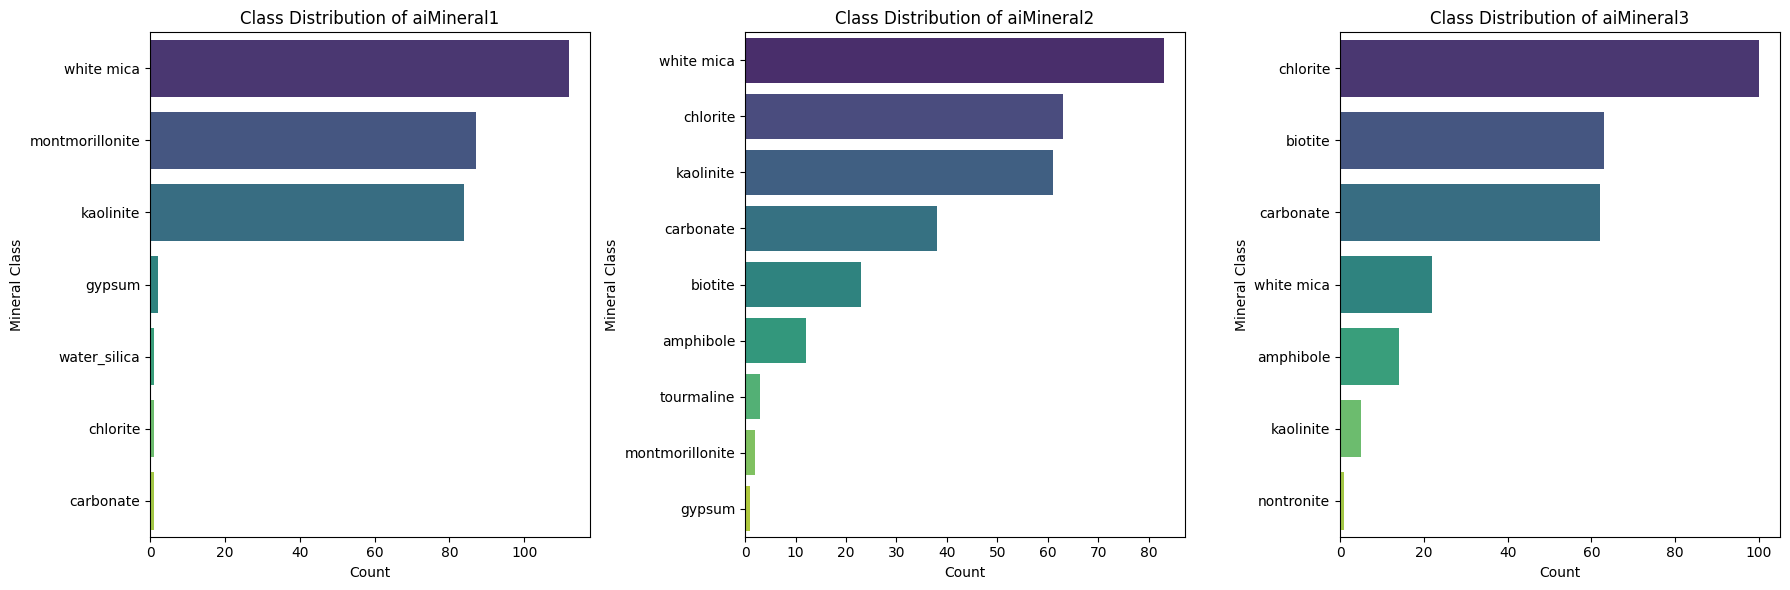

In [292]:
# Define primary mineral columns
primary_minerals = ["aiMineral1", "aiMineral2", "aiMineral3"]

# Plot class distribution for each primary mineral
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(primary_minerals):
    sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Class Distribution of {col}")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("Mineral Class")

plt.tight_layout()
plt.show()

AiMineral4-6 might be minor mineral class

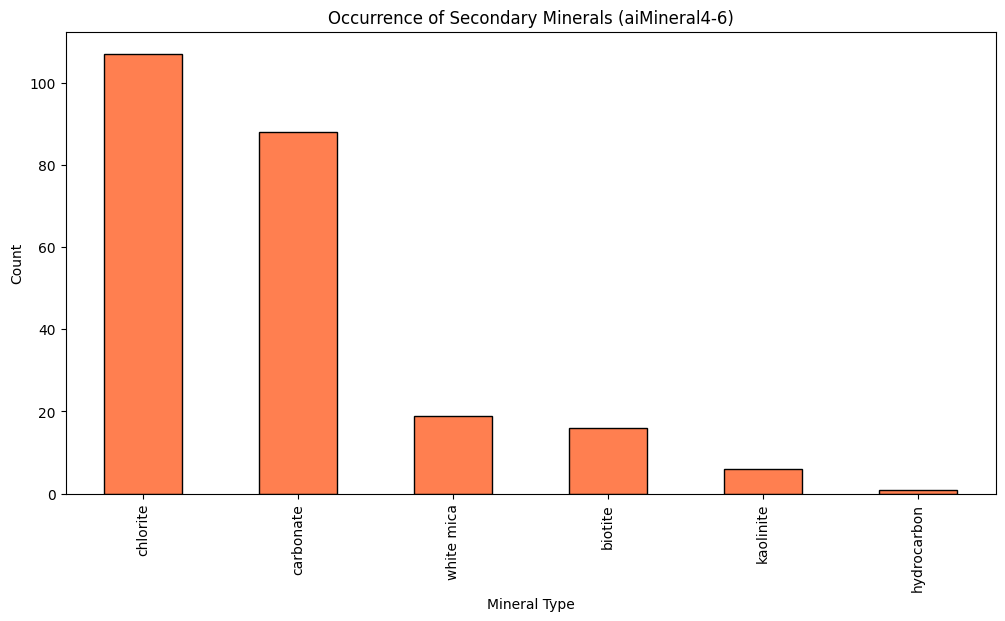

In [293]:
# Count occurrences of each secondary mineral
aiMineral_columns = ["aiMineral4", "aiMineral5", "aiMineral6"]
secondary_mineral_counts = df[aiMineral_columns].melt(var_name="Mineral Class", value_name="Mineral").groupby("Mineral").size()

# Plot stacked bar chart
plt.figure(figsize=(12, 6))
secondary_mineral_counts.sort_values(ascending=False).plot(kind="bar", color="coral", edgecolor="black")
plt.title("Occurrence of Secondary Minerals (aiMineral4-6)")
plt.xlabel("Mineral Type")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

 Plot Total Mineral Frequency Across aiMineral1-6

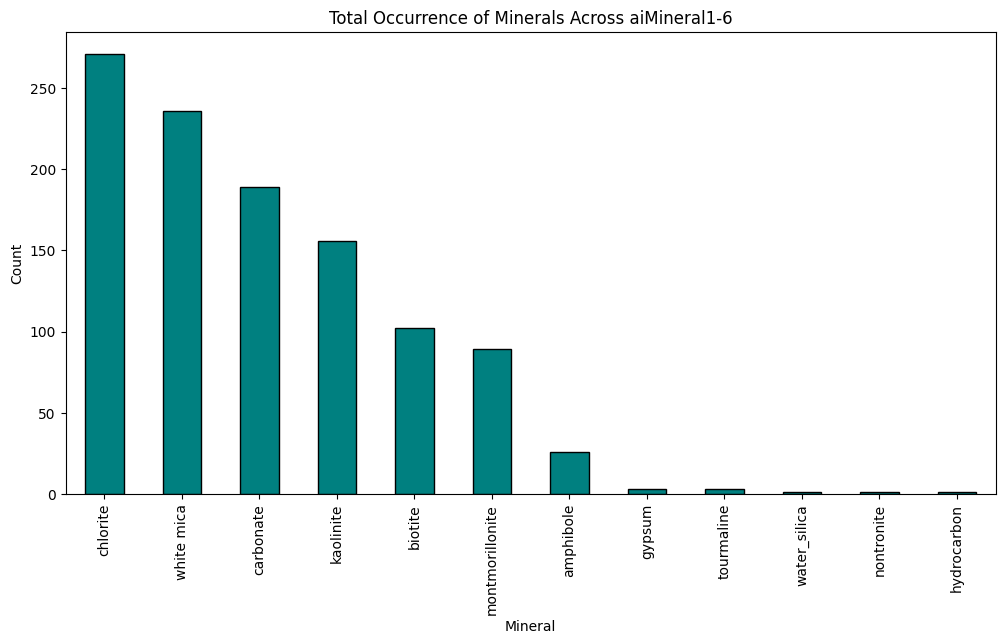

In [294]:
# Combine aiMineral1-6 into a single column and count occurrences
all_minerals = df[["aiMineral1", "aiMineral2", "aiMineral3", "aiMineral4", "aiMineral5", "aiMineral6"]].melt(value_name="Mineral")
mineral_counts = all_minerals["Mineral"].value_counts()

# Plot total occurrences
plt.figure(figsize=(12, 6))
mineral_counts.sort_values(ascending=False).plot(kind="bar", color="teal", edgecolor="black")
plt.title("Total Occurrence of Minerals Across aiMineral1-6")
plt.xlabel("Mineral")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

Heatmap of Primary Mineral and Secondary Co-Occurrences

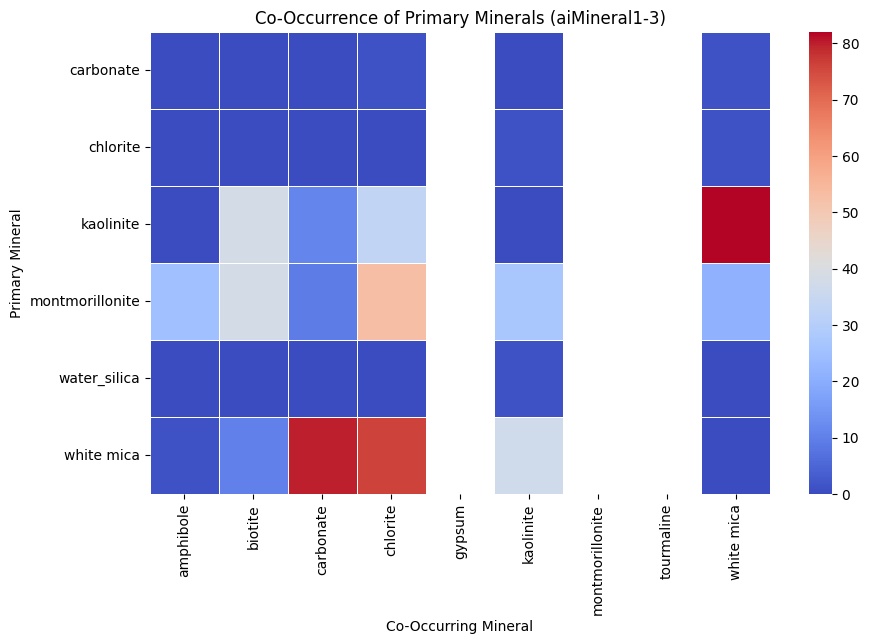

In [295]:
# ✅ Convert aiMineral1-3 into a co-occurrence matrix
co_occurrence_primary = pd.crosstab(index=df["aiMineral1"], columns=df["aiMineral2"])
for col in ["aiMineral3"]:
    co_occurrence_primary += pd.crosstab(index=df["aiMineral1"], columns=df[col])

# ✅ Plot co-occurrence heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(co_occurrence_primary, cmap="coolwarm", linewidths=0.5)
plt.title("Co-Occurrence of Primary Minerals (aiMineral1-3)")
plt.xlabel("Co-Occurring Mineral")
plt.ylabel("Primary Mineral")
plt.show()

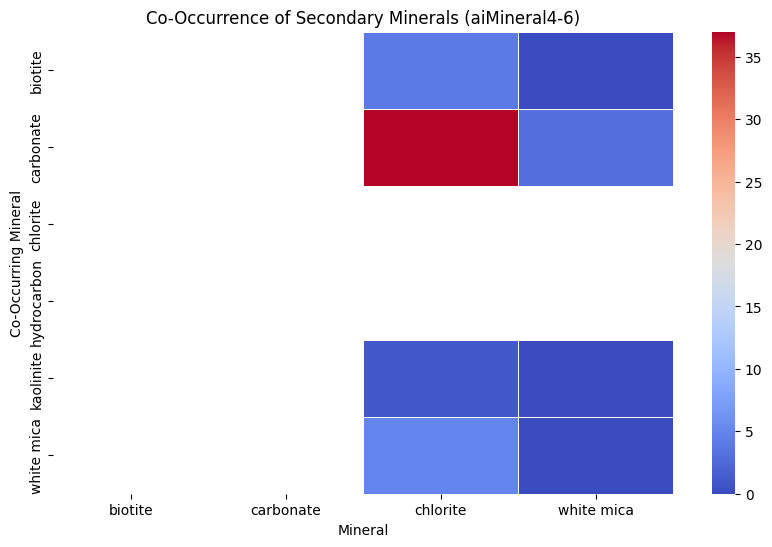

In [296]:
# ✅ Convert aiMineral4-6 into a binary co-occurrence matrix
co_occurrence_matrix = pd.crosstab(index=df["aiMineral4"], columns=df["aiMineral5"])
for col in ["aiMineral6"]:
    co_occurrence_matrix += pd.crosstab(index=df["aiMineral4"], columns=df[col])

# ✅ Plot co-occurrence heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(co_occurrence_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Co-Occurrence of Secondary Minerals (aiMineral4-6)")
plt.xlabel("Mineral")
plt.ylabel("Co-Occurring Mineral")
plt.show()

### 2.4.2 Check Feature Distributions

Since there are too many features after mergeing the spectral data and metadata (Labels + 350-2500 nm Spectral Data),  plotting all feature distributions and correlations at once is slow and inefficient. So, I divide the features into three groups and analyze them separately.

Group 1: Categorical Labels;

Group 2: Non-Spectral Features;

Group 3: Spectral Data (350-2500 nm).

Check Non-Spectral Numerical Features Distributions (Separate by Group):

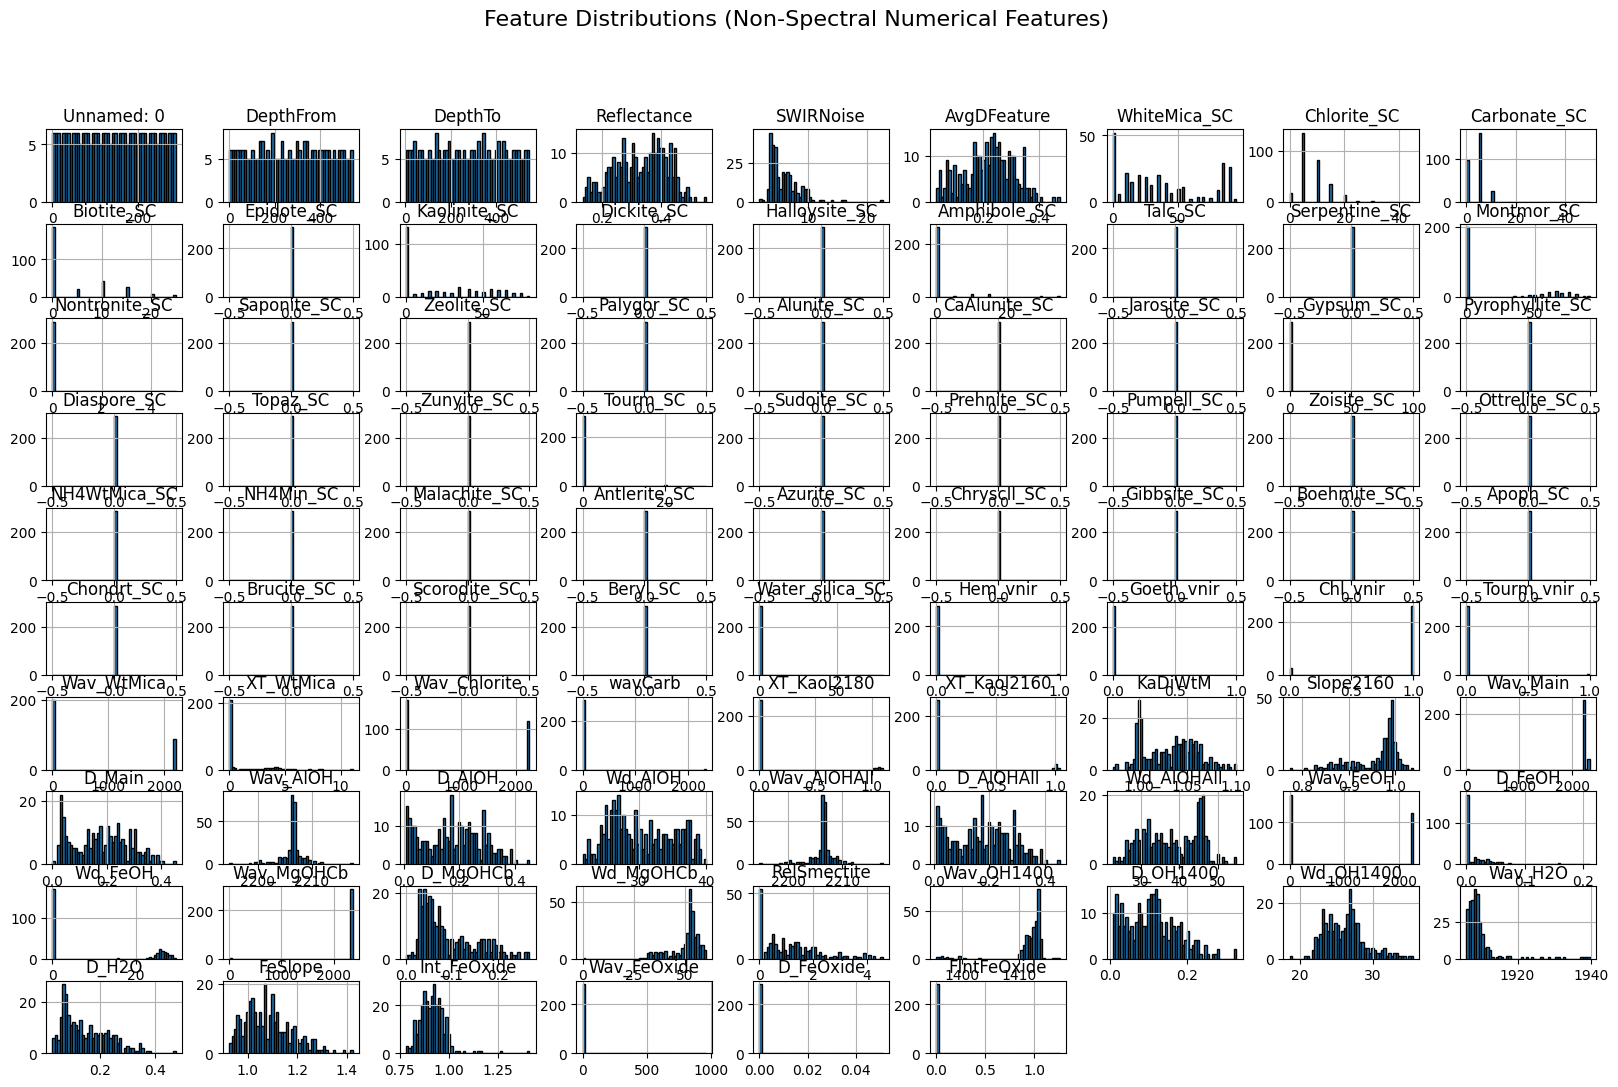

In [297]:
# Identify non-spectral numerical features (exclude wavelengths)
numerical_features = [col for col in df.columns if not col.replace(".", "").isdigit()]  # Excludes 350-2500 nm columns

# Plot histograms
df[numerical_features].hist(figsize=(20, 12), bins=50, edgecolor="black")
plt.suptitle("Feature Distributions (Non-Spectral Numerical Features)", fontsize=16)
plt.show()

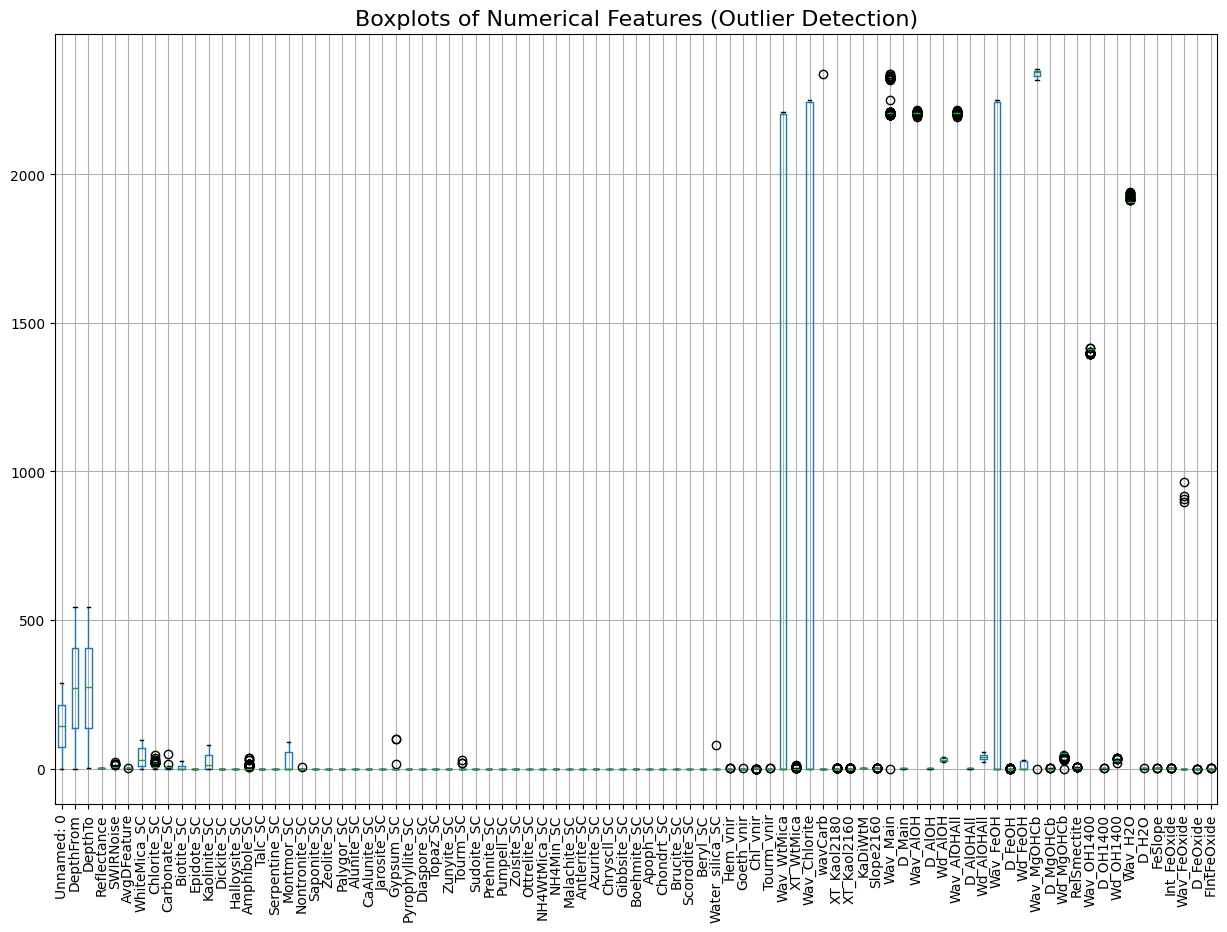

In [298]:
# Using Boxplots for check visualize outliers in each numerical feature
plt.figure(figsize=(15, 10))
df[numerical_features].boxplot(rot=90)
plt.title("Boxplots of Numerical Features (Outlier Detection)", fontsize=16)
plt.xticks(rotation=90)
plt.show()

Check Non-Spectral Feature Correlations by using Correlation Heatmap

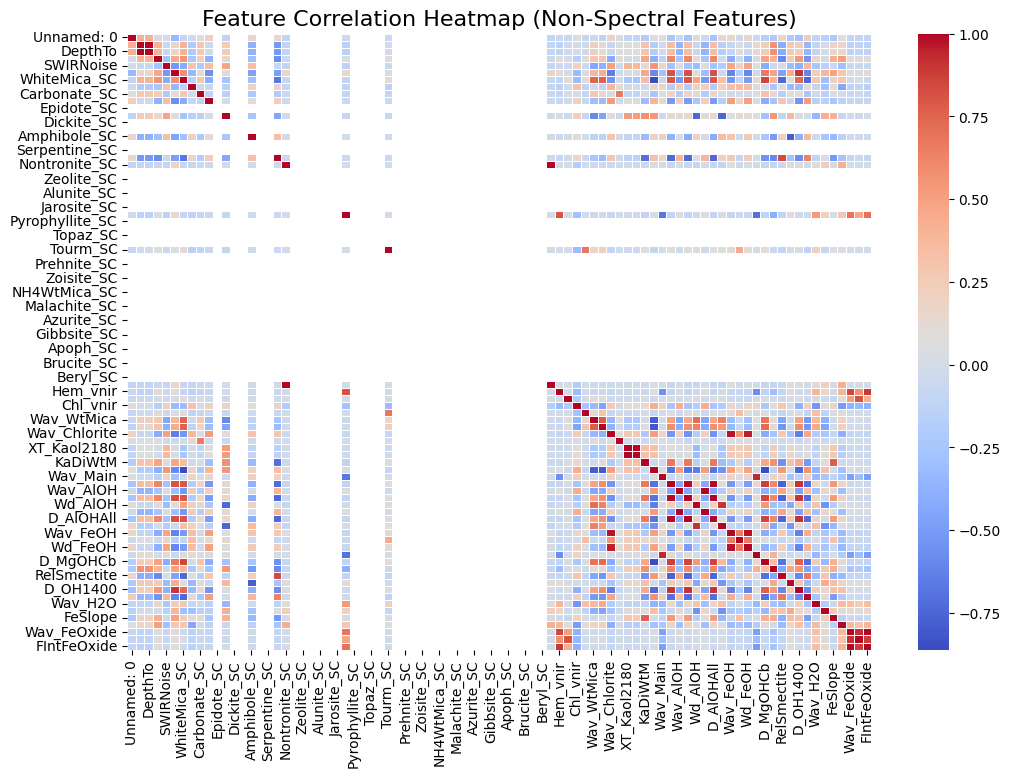

In [299]:
# Remove spectral wavelength columns (350-2500 nm)
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
non_spectral_features = [col for col in numerical_features if not col.replace(".", "").isdigit()]

# Compute correlation matrix for non-spectral numerical features
corr_matrix = df[non_spectral_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Non-Spectral Features)", fontsize=16)
plt.show()

# 3. Initial Machine Learning for simple Models

## 3.1 Feature Selection (find most important wavelengths) for aiMineral1

Remove Redundant Wavelengths (Low Variance), it could reduce highly redundant spectral features.

In [300]:
from sklearn.feature_selection import VarianceThreshold

In [301]:
# Extract only spectral wavelength columns (350-2500 nm)
spectral_features = [col for col in df.columns if col.replace(".", "").isdigit()]
X = df[spectral_features]

In [302]:
# Apply Variance Thresholding (removes nearly constant wavelengths)
var_thresh = VarianceThreshold(threshold=0.002)  # Remove features with variance < 0.01
X_reduced = var_thresh.fit_transform(X)

In [303]:
#  Keep only selected feature names
selected_wavelengths = X.columns[var_thresh.get_support()]
print(f"Selected Wavelengths: {(selected_wavelengths)} features")

Selected Wavelengths: Index(['603.0', '604.0', '605.0', '606.0', '607.0', '608.0', '609.0', '610.0',
       '611.0', '612.0',
       ...
       '2441.0', '2442.0', '2443.0', '2444.0', '2445.0', '2446.0', '2447.0',
       '2448.0', '2449.0', '2450.0'],
      dtype='object', length=1467) features


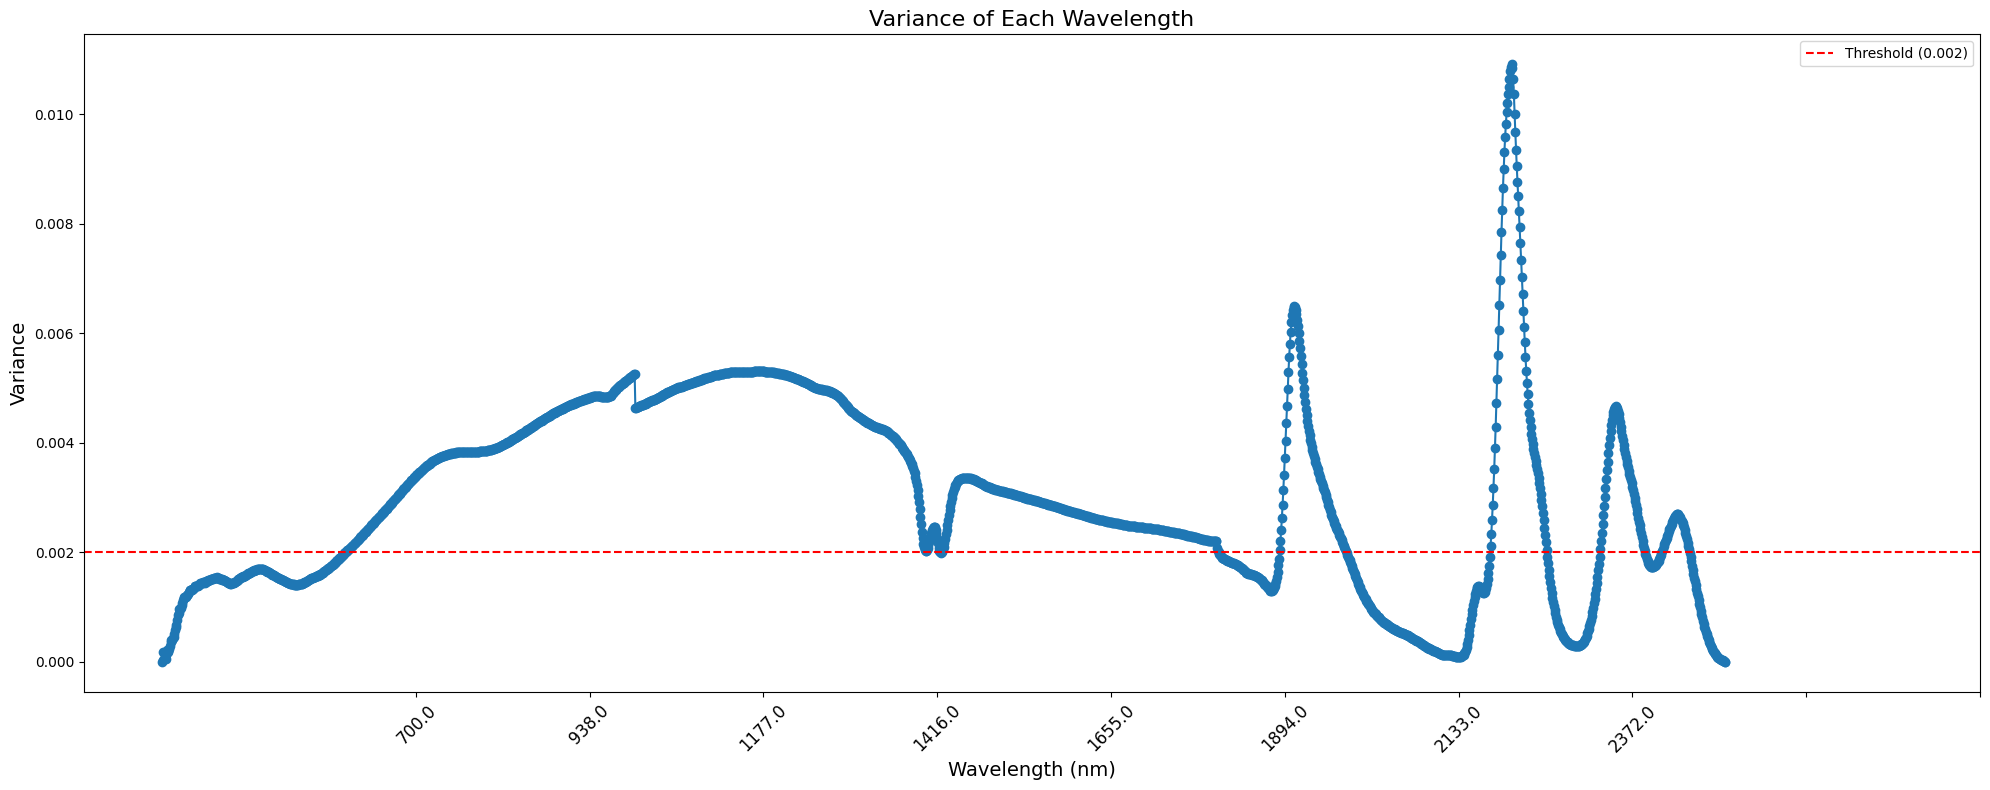

In [304]:
# Visualize Variance Across Wavelengths
variances = X.var(axis=0)
plt.figure(figsize=(20,8))
plt.plot(X.columns, variances, marker='o', linestyle='-')
plt.axhline(y=0.002, color='r', linestyle='--', label="Threshold (0.002)")
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.title("Variance of Each Wavelength", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.xticks(np.linspace(350, 2500, num=10, dtype=int))
plt.tight_layout()
plt.legend()
plt.show()

Correlation Analysis

In [305]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr

# Create a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder to the 'aiMineral1' column and transform it
df["aiMineral1_encoded"] = encoder.fit_transform(df["aiMineral1"])

In [306]:
# Compute Pearson correlation between wavelengths and aiMineral1 (encoded)
correlations = df[selected_wavelengths].corrwith(df["aiMineral1_encoded"])

<ipython-input-307-02183a2550f7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_wavelengths.index, y=top_corr_wavelengths.values, palette="viridis")


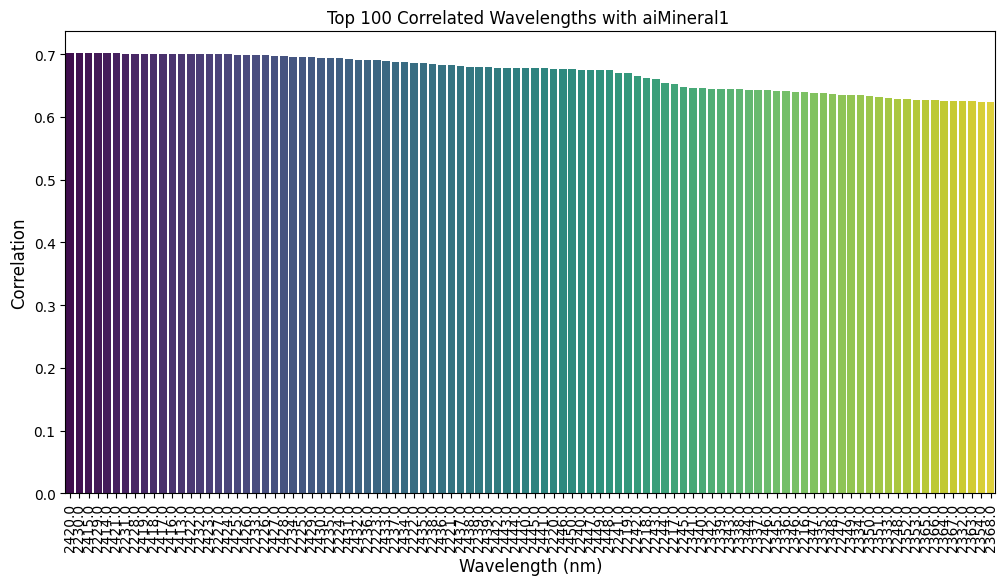

In [307]:
# Visualization: Bar plot of selected wavelengths
top_corr_wavelengths = correlations.abs().sort_values(ascending=False).head(100)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_corr_wavelengths.index, y=top_corr_wavelengths.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 100 Correlated Wavelengths with aiMineral1 ")
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.show()

Train a Linear Regression Model & Analyze Coefficients

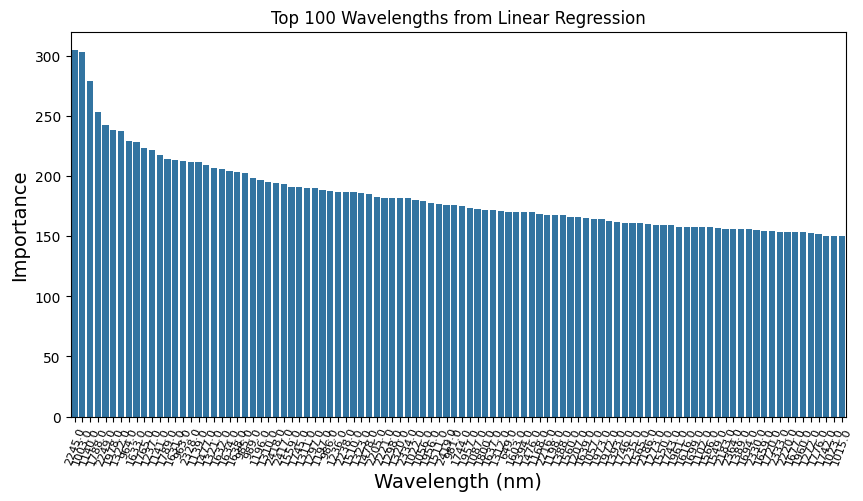

In [388]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# ✅ Train Linear Regression on Selected Wavelengths
X_train, X_test, y_train, y_test = train_test_split(df[selected_wavelengths], df["aiMineral1_encoded"], test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

# ✅ Get Absolute Coefficients
feature_importance = np.abs(lr.coef_)

# ✅ Rank Top 20 Wavelengths by Importance
top_features = sorted(zip(selected_wavelengths, feature_importance), key=lambda x: x[1], reverse=True)[:100]

# ✅ Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=[f[0] for f in top_features], y=[f[1] for f in top_features])
plt.xticks(rotation=70, fontsize=8)
plt.title("Top 100 Wavelengths from Linear Regression")
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.show()


Compare with Random Forest Feature Importance

In [389]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier for Comparison
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

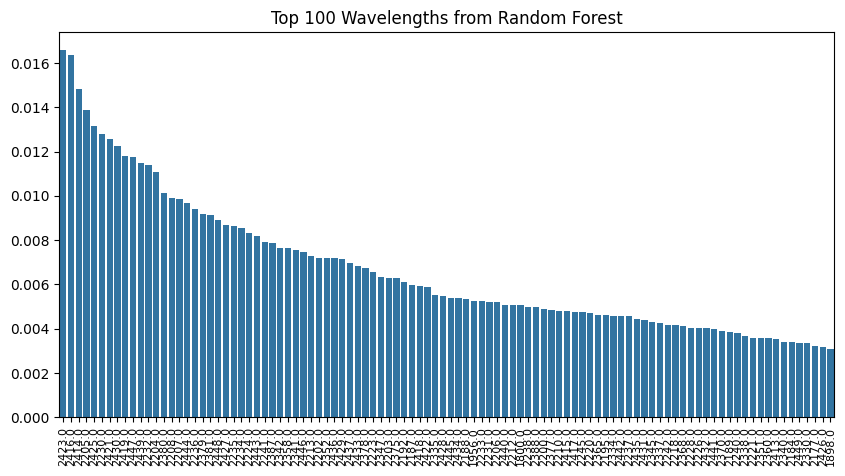

In [390]:
# Get Feature Importances
rf_importance = rf.feature_importances_

# Rank Top 50 Wavelengths
top_rf_features = sorted(zip(selected_wavelengths, rf_importance), key=lambda x: x[1], reverse=True)[:100]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=[f[0] for f in top_rf_features], y=[f[1] for f in top_rf_features])
plt.xticks(rotation=90,fontsize=8)
plt.title("Top 100 Wavelengths from Random Forest")
plt.show()

Combine Feature Selection Results

In [391]:
# 1. Extract features from each method
variance_selected_wavelengths = set(var_thresh.get_support(indices=True))  # Variance thresholding

# Add this line to get the top correlated wavelengths from the 'corr_df' DataFrame:
variance_selected_wavelengths = set(var_thresh.get_support(indices=True))  # Variance thresholding
correlation_selected_wavelengths = set(top_corr_wavelengths.index)  # Top correlated with aiMineral1
linear_reg_selected_wavelengths = set([f[0] for f in top_features])  # Top LR coefficients
rf_selected_wavelengths = set([f[0] for f in top_rf_features])  # Top RF feature importance

# 2. Combine Features Using Different Approaches
intersection_wavelengths = variance_selected_wavelengths & correlation_selected_wavelengths & linear_reg_selected_wavelengths & rf_selected_wavelengths
union_wavelengths = variance_selected_wavelengths | correlation_selected_wavelengths | linear_reg_selected_wavelengths | rf_selected_wavelengths

print(f"Intersection (Strict): {(intersection_wavelengths)} wavelengths selected")
print(f"Union (Broad): {len(union_wavelengths)} wavelengths selected")


Intersection (Strict): set() wavelengths selected
Union (Broad): 1685 wavelengths selected


Compute Weighted Importance Score

In [392]:
from collections import Counter

# Count how many times each wavelength was selected
wavelength_counts = Counter(
    list(variance_selected_wavelengths) +
    list(correlation_selected_wavelengths) +
    list(linear_reg_selected_wavelengths) +
    list(rf_selected_wavelengths)
)

# Sort wavelengths by importance (most frequently selected first)
sorted_wavelengths = sorted(wavelength_counts.items(), key=lambda x: x[1], reverse=True)

# Select top N most frequent wavelengths
top_wavelengths = [w[0] for w in sorted_wavelengths if w[1] >= 3]  # Appears in at least 3 methods
print(f"Top {(top_wavelengths)} Wavelengths Selected")


Top ['2417.0', '2419.0', '2221.0', '2418.0', '2238.0', '2220.0', '2245.0', '2334.0'] Wavelengths Selected


Visualize Selected Wavelengths

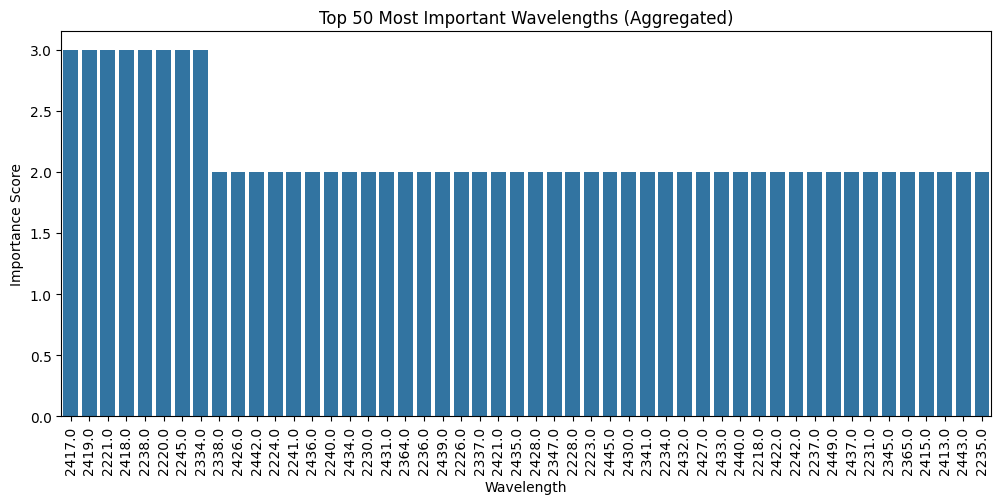

In [393]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame for Visualization
importance_df = pd.DataFrame(sorted_wavelengths, columns=["Wavelength", "Importance Score"])

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="Wavelength", y="Importance Score", data=importance_df.head(50))
plt.xticks(rotation=90)
plt.title("Top 50 Most Important Wavelengths (Aggregated)")
plt.show()


In [394]:
# Apply Threshold-Based Selection (Keep Importance Score ≥ 2)
top_selected_wavelengths = importance_df[importance_df["Importance Score"] >= 2]["Wavelength"].tolist()

print(f"Final Selected Wavelengths: {top_selected_wavelengths}")
print(f"Total Wavelengths Selected: {len(top_selected_wavelengths)}")


Final Selected Wavelengths: ['2417.0', '2419.0', '2221.0', '2418.0', '2238.0', '2220.0', '2245.0', '2334.0', '2338.0', '2426.0', '2442.0', '2224.0', '2241.0', '2436.0', '2240.0', '2434.0', '2230.0', '2431.0', '2364.0', '2236.0', '2439.0', '2226.0', '2337.0', '2421.0', '2435.0', '2428.0', '2347.0', '2228.0', '2223.0', '2445.0', '2430.0', '2341.0', '2234.0', '2432.0', '2427.0', '2433.0', '2440.0', '2218.0', '2422.0', '2242.0', '2237.0', '2449.0', '2437.0', '2231.0', '2345.0', '2365.0', '2415.0', '2413.0', '2443.0', '2235.0', '2340.0', '2425.0', '2352.0', '2423.0', '2342.0', '2233.0', '2414.0', '2447.0', '2232.0', '2416.0', '2429.0', '2441.0', '2368.0', '2335.0', '2351.0', '2333.0', '2444.0', '2446.0', '2216.0', '2448.0', '2330.0', '1800.0', '1956.0', '2205.0']
Total Wavelengths Selected: 74


In [395]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [396]:
print(df.columns)

Index(['Spectrum', 'FileName', 'DepthFrom', 'DepthTo', 'SWIRMinerals',
       'SWIRMin_nowt', 'aiMineral1', 'aiMineral2', 'aiMineral3', 'aiMineral4',
       ...
       '2492.0', '2493.0', '2494.0', '2495.0', '2496.0', '2497.0', '2498.0',
       '2499.0', '2500.0', 'aiMineral1_encoded'],
      dtype='object', length=2257)


## 3.2 Train the Final Linear Regression Model

In [397]:
from sklearn.metrics import mean_squared_error

# Now select the columns
X_selected = df[top_selected_wavelengths]

y = df["aiMineral1_encoded"]  # Target variable

# Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on Test Set
y_pred = lr.predict(X_test)

# Compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Linear Regression RMSE: {rmse:.4f}")


Final Linear Regression RMSE: 1.0124


In [398]:
unique_classes = df['aiMineral1'].unique()
print(unique_classes)
print("Total unique mineral classes:", len(unique_classes))

['water_silica' 'montmorillonite' 'white mica' 'kaolinite' 'chlorite'
 'gypsum' 'carbonate']
Total unique mineral classes: 7


Since Linear Regression predicts continuous values, we need to round and map them back to minerals. Convert Predictions Back to Mineral Names

In [399]:
# Round Predictions to Closest Mineral Label
y_pred_rounded = np.round(y_pred).astype(int)

# Initialize the LabelEncoder if it hasn't been already
le = LabelEncoder()
le.fit(df['aiMineral1']) # Fit the encoder to the 'aiMineral1' column

# Ensure Predictions Stay Within Valid Range
y_pred_rounded = np.clip(y_pred_rounded, 0, len(le.classes_) - 1)

# Convert Numeric Predictions Back to Mineral Names
predicted_minerals = le.inverse_transform(y_pred_rounded)

# Compare Actual vs. Predicted
comparison_df = pd.DataFrame({
    "Actual Mineral": le.inverse_transform(y_test.values),
    "Predicted Mineral": predicted_minerals
})

comparison_df

Actual Mineral Predicted Mineral
0        white mica        white mica
1         kaolinite      water_silica
2   montmorillonite   montmorillonite
3   montmorillonite   montmorillonite
4        white mica      water_silica
5         kaolinite         kaolinite
6        white mica        white mica
7        white mica      water_silica
8   montmorillonite         kaolinite
9         kaolinite   montmorillonite
10       white mica        white mica
11        kaolinite         kaolinite
12        kaolinite            gypsum
13  montmorillonite   montmorillonite
14       white mica      water_silica
15       white mica        white mica
16  montmorillonite   montmorillonite
17       white mica        white mica
18       white mica      water_silica
19       white mica        white mica
20  montmorillonite   montmorillonite
21        kaolinite         kaolinite
22        kaolinite            gypsum
23  montmorillonite   montmorillonite
24       white mica        white mica
25  montmorillonite   montmorillonite
26  montmorillonite   montmorillonite
27        kaolinite         kaolinite
28       white mica      water_silica
29       white mica   montmorillonite
30       white mica        white mica
31       white mica         kaolinite
32        kaolinite            gypsum
33       white mica        white mica
34        kaolinite   montmorillonite
35       white mica   montmorillonite
36  montmorillonite   montmorillonite
37       white mica   montmorillonite
38        kaolinite         kaolinite
39       white mica        white mica
40        kaolinite      water_silica
41  montmorillonite   montmorillonite
42        kaolinite         kaolinite
43        kaolinite   montmorillonite
44        kaolinite         kaolinite
45  montmorillonite   montmorillonite
46       white mica         kaolinite
47        kaolinite   montmorillonite
48       white mica      water_silica
49        kaolinite   montmorillonite
50       white mica      water_silica
51  montmorillonite   montmorillonite
52       white mica      water_silica
53       white mica      water_silica
54       white mica      water_silica
55        kaolinite   montmorillonite
56  montmorillonite   montmorillonite
57       white mica   montmorillonite

In [400]:
# show the len of test dataset

print(len(X_test))


58


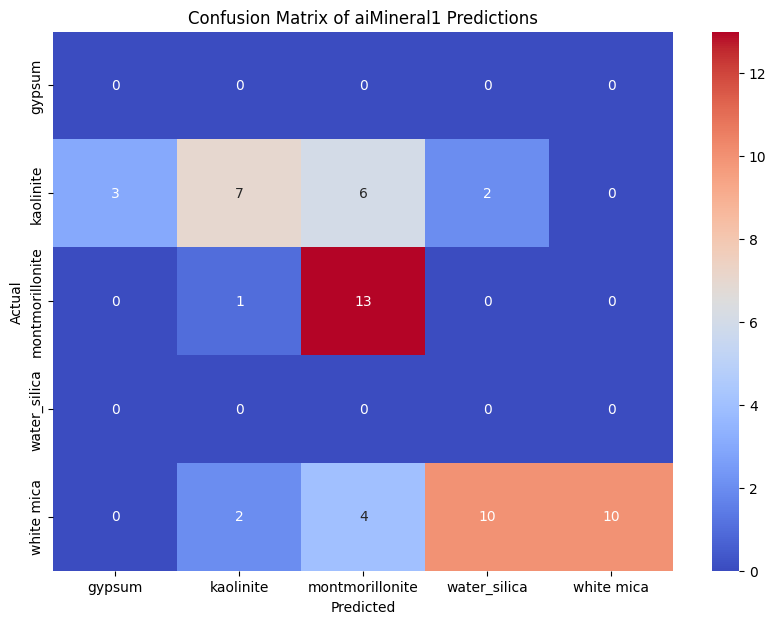

In [401]:
# Compute Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_rounded)

# Get unique classes present in the test data
unique_classes_test = np.unique(np.concatenate((y_test, y_pred_rounded)))

# Filter le.classes_ to include only classes present in the test data
filtered_classes = [c for c in le.classes_ if le.transform([c])[0] in unique_classes_test]

# Create DataFrame with filtered classes
df_cm = pd.DataFrame(conf_matrix, index=filtered_classes, columns=filtered_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="coolwarm")
plt.title("Confusion Matrix of aiMineral1 Predictions")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [402]:
# evaluate the accuarcy

from sklearn.metrics import accuracy_score,classification_report

accuracy_log_lr = accuracy_score(y_test, y_pred_rounded)

# convert y_test and y_pred to mineral names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_rounded)
print(f"Linear Regression Accuracy: {accuracy_log_lr:.4f}")
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

Linear Regression Accuracy: 0.5172
Classification Report:
                  precision    recall  f1-score   support

         gypsum       0.00      0.00      0.00         0
      kaolinite       0.70      0.39      0.50        18
montmorillonite       0.57      0.93      0.70        14
   water_silica       0.00      0.00      0.00         0
     white mica       1.00      0.38      0.56        26

       accuracy                           0.52        58
      macro avg       0.45      0.34      0.35        58
   weighted avg       0.80      0.52      0.57        58



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3.3 Try other classfication Models

Prepare Data for Logistic Regression, Random Forest & Decision Tree Models

In [405]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [406]:
# Encode target labels
label_encoder = LabelEncoder()
df["aiMineral1_encoded"] = label_encoder.fit_transform(df["aiMineral1"])

# Define Features (X) and Labels (y)
X = df[top_selected_wavelengths]
y = df['aiMineral1_encoded']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [407]:
# Normalize features (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [408]:
print(le.classes_)

['carbonate' 'chlorite' 'gypsum' 'kaolinite' 'montmorillonite'
 'water_silica' 'white mica']


Train and Evaluate Logistic Regression

In [409]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_logreg = log_reg.predict(X_test_scaled)

# Evaluate performance White
accuracy_log = accuracy_score(y_test, y_pred_logreg)
# convert y_test and y_pred to mineral names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_log:.4f}")
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

Logistic Regression Accuracy: 0.8793
Classification Report:
                  precision    recall  f1-score   support

      kaolinite       0.77      0.94      0.85        18
montmorillonite       0.87      0.93      0.90        14
     white mica       1.00      0.81      0.89        26

       accuracy                           0.88        58
      macro avg       0.88      0.89      0.88        58
   weighted avg       0.90      0.88      0.88        58



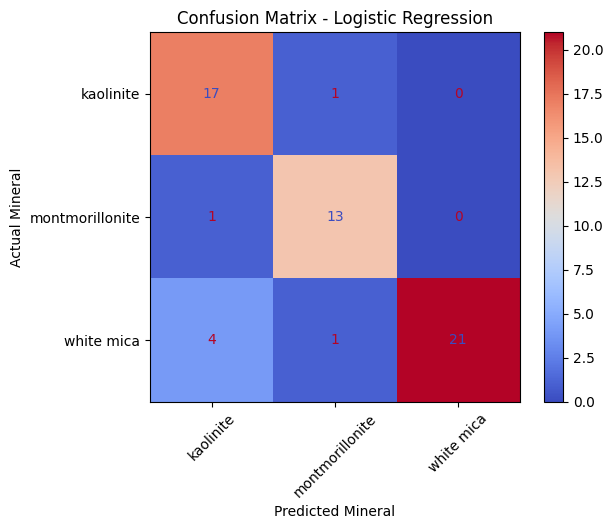

In [410]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Get only the labels present in y_test (actual) & y_pred_logreg (predicted)
unique_labels = np.unique(np.concatenate((y_test, y_pred_logreg)))  # Get only the used labels

# Convert encoded labels back to mineral names
label_names = le.inverse_transform(unique_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot the confusion matrix
disp.plot(cmap="coolwarm", xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Mineral")
plt.ylabel("Actual Mineral")
plt.show()

In [411]:
# Convert Numeric Predictions Back to Mineral Names
predicted_minerals_logreg = le.inverse_transform(y_pred_logreg)

# Compare Actual vs. Predicted
comparison_logreg = pd.DataFrame({
    "Actual Mineral": le.inverse_transform(y_test.values),
    "Predicted Mineral": predicted_minerals_logreg
})

# Print the comparisons
comparison_logreg

Actual Mineral Predicted Mineral
0        white mica        white mica
1         kaolinite         kaolinite
2   montmorillonite   montmorillonite
3   montmorillonite   montmorillonite
4        white mica        white mica
5         kaolinite   montmorillonite
6        white mica        white mica
7        white mica        white mica
8   montmorillonite   montmorillonite
9         kaolinite         kaolinite
10       white mica        white mica
11        kaolinite         kaolinite
12        kaolinite         kaolinite
13  montmorillonite   montmorillonite
14       white mica        white mica
15       white mica        white mica
16  montmorillonite   montmorillonite
17       white mica        white mica
18       white mica        white mica
19       white mica        white mica
20  montmorillonite   montmorillonite
21        kaolinite         kaolinite
22        kaolinite         kaolinite
23  montmorillonite   montmorillonite
24       white mica        white mica
25  montmorillonite   montmorillonite
26  montmorillonite         kaolinite
27        kaolinite         kaolinite
28       white mica        white mica
29       white mica        white mica
30       white mica        white mica
31       white mica         kaolinite
32        kaolinite         kaolinite
33       white mica        white mica
34        kaolinite         kaolinite
35       white mica         kaolinite
36  montmorillonite   montmorillonite
37       white mica        white mica
38        kaolinite         kaolinite
39       white mica        white mica
40        kaolinite         kaolinite
41  montmorillonite   montmorillonite
42        kaolinite         kaolinite
43        kaolinite         kaolinite
44        kaolinite         kaolinite
45  montmorillonite   montmorillonite
46       white mica         kaolinite
47        kaolinite         kaolinite
48       white mica        white mica
49        kaolinite         kaolinite
50       white mica        white mica
51  montmorillonite   montmorillonite
52       white mica        white mica
53       white mica         kaolinite
54       white mica        white mica
55        kaolinite         kaolinite
56  montmorillonite   montmorillonite
57       white mica   montmorillonite

Train and Evaluate Random Forest

In [412]:
# Train Random Forest model
from sklearn.metrics import ConfusionMatrixDisplay
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# convert y_test and y_pred to mineral names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

Random Forest Accuracy: 0.8448
Classification Report:
                  precision    recall  f1-score   support

      kaolinite       0.75      0.83      0.79        18
montmorillonite       0.86      0.86      0.86        14
     white mica       0.92      0.85      0.88        26

       accuracy                           0.84        58
      macro avg       0.84      0.85      0.84        58
   weighted avg       0.85      0.84      0.85        58



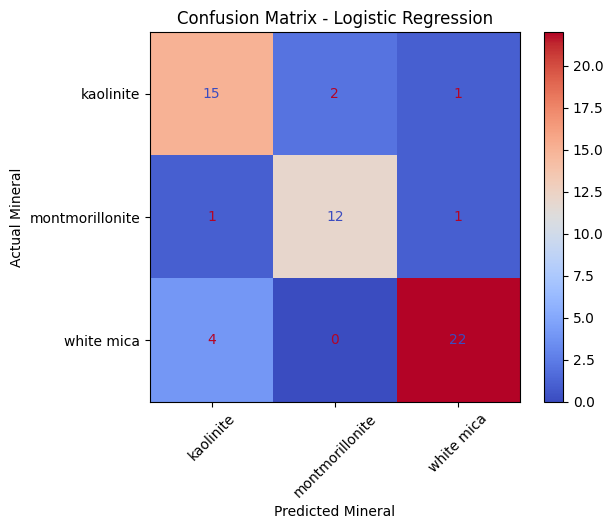

In [413]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Get only the labels present in y_test (actual) & y_pred_logreg (predicted)
unique_labels = np.unique(np.concatenate((y_test, y_pred_rf)))  # Get only the used labels

# Convert encoded labels back to mineral names
label_names = le.inverse_transform(unique_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot the confusion matrix
disp.plot(cmap="coolwarm", xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Mineral")
plt.ylabel("Actual Mineral")
plt.show()


In [414]:
# Convert Numeric Predictions Back to Mineral Names
predicted_minerals_rf = le.inverse_transform(y_pred_rf)

# Compare Actual vs. Predicted
comparison_rf = pd.DataFrame({
    "Actual Mineral": le.inverse_transform(y_test.values),
    "Predicted Mineral": predicted_minerals_rf
})

# Print the comparisons
comparison_rf

Actual Mineral Predicted Mineral
0        white mica        white mica
1         kaolinite        white mica
2   montmorillonite   montmorillonite
3   montmorillonite   montmorillonite
4        white mica        white mica
5         kaolinite         kaolinite
6        white mica        white mica
7        white mica        white mica
8   montmorillonite   montmorillonite
9         kaolinite         kaolinite
10       white mica         kaolinite
11        kaolinite         kaolinite
12        kaolinite         kaolinite
13  montmorillonite        white mica
14       white mica        white mica
15       white mica        white mica
16  montmorillonite   montmorillonite
17       white mica        white mica
18       white mica        white mica
19       white mica        white mica
20  montmorillonite   montmorillonite
21        kaolinite         kaolinite
22        kaolinite         kaolinite
23  montmorillonite   montmorillonite
24       white mica        white mica
25  montmorillonite   montmorillonite
26  montmorillonite         kaolinite
27        kaolinite         kaolinite
28       white mica        white mica
29       white mica        white mica
30       white mica        white mica
31       white mica         kaolinite
32        kaolinite         kaolinite
33       white mica        white mica
34        kaolinite         kaolinite
35       white mica         kaolinite
36  montmorillonite   montmorillonite
37       white mica        white mica
38        kaolinite         kaolinite
39       white mica        white mica
40        kaolinite         kaolinite
41  montmorillonite   montmorillonite
42        kaolinite         kaolinite
43        kaolinite         kaolinite
44        kaolinite   montmorillonite
45  montmorillonite   montmorillonite
46       white mica        white mica
47        kaolinite   montmorillonite
48       white mica        white mica
49        kaolinite         kaolinite
50       white mica        white mica
51  montmorillonite   montmorillonite
52       white mica        white mica
53       white mica         kaolinite
54       white mica        white mica
55        kaolinite         kaolinite
56  montmorillonite   montmorillonite
57       white mica        white mica

Train and Evaluate Decision Tree

In [415]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
# convert y_test and y_pred to mineral names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

Decision Tree Accuracy: 0.7759
Classification Report:
                  precision    recall  f1-score   support

      kaolinite       0.65      0.83      0.73        18
montmorillonite       0.91      0.71      0.80        14
     white mica       0.83      0.77      0.80        26

       accuracy                           0.78        58
      macro avg       0.80      0.77      0.78        58
   weighted avg       0.80      0.78      0.78        58



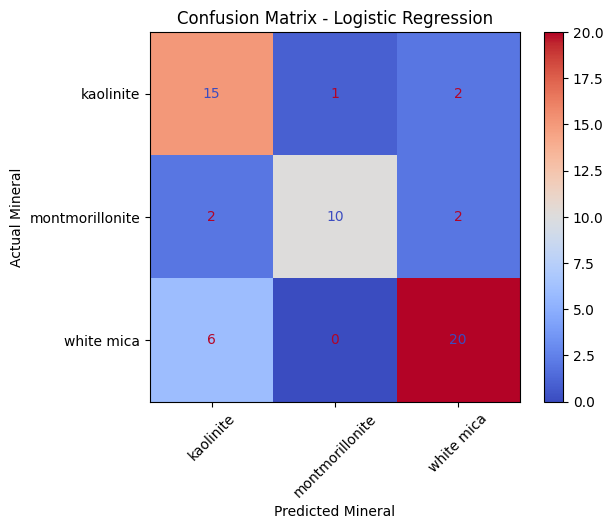

In [416]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Get only the labels present in y_test (actual) & y_pred_logreg (predicted)
unique_labels = np.unique(np.concatenate((y_test, y_pred_dt)))  # Get only the used labels

# Convert encoded labels back to mineral names
label_names = le.inverse_transform(unique_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot the confusion matrix
disp.plot(cmap="coolwarm", xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Mineral")
plt.ylabel("Actual Mineral")
plt.show()

In [417]:
# Convert Numeric Predictions Back to Mineral Names
predicted_minerals_dt = le.inverse_transform(y_pred_dt)

# Compare Actual vs. Predicted
comparison_dt = pd.DataFrame({
    "Actual Mineral": le.inverse_transform(y_test.values),
    "Predicted Mineral": predicted_minerals_dt
})

# Print the comparisons
comparison_dt

Actual Mineral Predicted Mineral
0        white mica        white mica
1         kaolinite        white mica
2   montmorillonite   montmorillonite
3   montmorillonite   montmorillonite
4        white mica         kaolinite
5         kaolinite         kaolinite
6        white mica        white mica
7        white mica        white mica
8   montmorillonite        white mica
9         kaolinite   montmorillonite
10       white mica         kaolinite
11        kaolinite         kaolinite
12        kaolinite         kaolinite
13  montmorillonite   montmorillonite
14       white mica        white mica
15       white mica        white mica
16  montmorillonite   montmorillonite
17       white mica        white mica
18       white mica        white mica
19       white mica        white mica
20  montmorillonite   montmorillonite
21        kaolinite         kaolinite
22        kaolinite         kaolinite
23  montmorillonite   montmorillonite
24       white mica        white mica
25  montmorillonite   montmorillonite
26  montmorillonite         kaolinite
27        kaolinite         kaolinite
28       white mica        white mica
29       white mica         kaolinite
30       white mica        white mica
31       white mica         kaolinite
32        kaolinite         kaolinite
33       white mica        white mica
34        kaolinite         kaolinite
35       white mica         kaolinite
36  montmorillonite        white mica
37       white mica        white mica
38        kaolinite         kaolinite
39       white mica        white mica
40        kaolinite         kaolinite
41  montmorillonite   montmorillonite
42        kaolinite        white mica
43        kaolinite         kaolinite
44        kaolinite         kaolinite
45  montmorillonite         kaolinite
46       white mica        white mica
47        kaolinite         kaolinite
48       white mica        white mica
49        kaolinite         kaolinite
50       white mica        white mica
51  montmorillonite   montmorillonite
52       white mica        white mica
53       white mica         kaolinite
54       white mica        white mica
55        kaolinite         kaolinite
56  montmorillonite   montmorillonite
57       white mica        white mica

Compare Model Performance

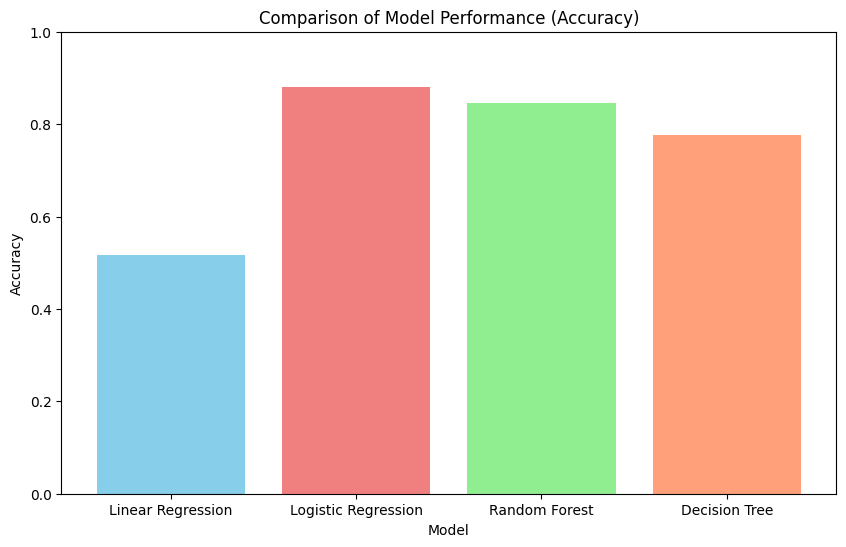

In [418]:
# Summarize results and plot Compare Model Performance
models = ['Linear Regression', 'Logistic Regression', 'Random Forest', 'Decision Tree']
accuracy_scores = [accuracy_log_lr, accuracy_log, accuracy_rf, accuracy_dt]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon'])
plt.title('Comparison of Model Performance (Accuracy)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.show()


In [419]:
y_train.value_counts()

aiMineral1_encoded
6    86
4    73
3    66
2     2
5     1
1     1
0     1
Name: count, dtype: int64

In [420]:
y_test.value_counts()

aiMineral1_encoded
6    26
3    18
4    14
Name: count, dtype: int64